# parPE steadystate example model

In [58]:
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

example_data_dir = f'{parpe_build_root}/amici/examples/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/amici/examples/steadystate/'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

In [59]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# load parpe module from source tree
sys.path.insert(0, os.path.join(parpe_source_root, 'python'))
import parpe

In [60]:
# rebuild example
!cd {parpe_build_root} && make

-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Building version parPE-v0.1.8-96-gf6aa3-dirty
[  0%] Built target get_version
[  8%] Built target parpecommon
[ 11%] Built target parpeloadbalancer
[ 21%] Built target parpeoptimization
[ 31%] Built target parpeamici
[ 32%] Built target parpe
[ 37%] Built target unittests_common
[ 42%] Built target unittests_optimization_ipopt
[ 51%] Built target unittests_optimization
[ 55%] Built target unittests_optimization_ceres
[ 58%] Built target unittests_loadbalancer
[ 61%] Built target example_loadbalancer
[ 70%] Built target steadystate_scaled
[ 73%] Built target example_steadystate
[ 78%] Built target example_steadystate_parallel
[ 82%] Built target example_steadystate_multi
[ 85%] Built target example_steadystate_multi_simulator
[ 90%] Built target test_steadystate
[100%] Built target unittests_amici


## Test simulation

In [61]:
# load model
model_output_dir = os.path.join(example_data_dir, 'model_steadystate_scaled')
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'ptr': <amici.amici.ReturnDataPtr; proxy of <Swig Object of type 'std::unique_ptr< amici::ReturnData > *' at 0x7f8c56c846f0> >, 't': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 

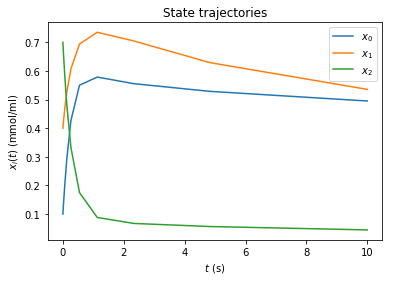

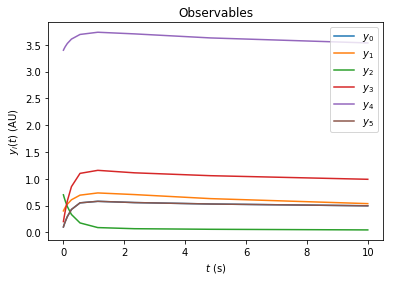

In [62]:
from amici.plotting import plotStateTrajectories
from amici.plotting import plotObservableTrajectories

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)

## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [6]:
# enable derivate checker
#!{optimizationOptionsPy} {example_data_dir}/example_data.h5 -s ipopt/derivative_test first-order
#!{optimizationOptionsPy} {example_data_dir}/example_data.h5 -s ipopt/derivative_test_print_all yes
!{optimizationOptionsPy} {example_data_dir}/example_data.h5 -s numStarts 2
!{optimizationOptionsPy} {example_data_dir}/example_data.h5 -s hierarchicalOptimization 0
!{optimizationOptionsPy} {example_data_dir}/example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            2
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Gradient check

In [7]:
for i in range(3):
    !PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {example_data_dir}/example_data.h5


[2019-01-11 16:28:04] [ERR] [-1/]     0 g: -6.69557e+13  fd_c:            0  Δ/fd_c: -6.695575e+18  f:  1.96112e+23
[2019-01-11 16:28:04] [ERR] [-1/]     1 g:  1.79445e+13  fd_c:            0  Δ/fd_c: 1.794453e+18  f:  1.96112e+23
[2019-01-11 16:28:04] [ERR] [-1/]     2 g:   2.2425e+10  fd_c:            0  Δ/fd_c: 2.242500e+15  f:  1.96112e+23
[2019-01-11 16:28:04] [ERR] [-1/]     3 g: -2.07968e+13  fd_c:            0  Δ/fd_c: -2.079683e+18  f:  1.96112e+23
[2019-01-11 16:28:04] [ERR] [-1/]     4 g: -1.71358e+14  fd_c:            0  Δ/fd_c: -1.713583e+19  f:  1.96112e+23
[2019-01-11 16:28:04] [ERR] [-1/]     5 g:  1.91305e+06  fd_c:            0  Δ/fd_c: 1.913051e+11  f:  1.96112e+23
[2019-01-11 16:28:04] [ERR] [-1/]     6 g: -3.85983e+13  fd_c:            0  Δ/fd_c: -3.859833e+18  f:  1.96112e+23
[2019-01-11 16:28:04] [ERR] [-1/]     7 g:     -571.271  fd_c:            0  Δ/fd_c: -5.712710e+07  f:  1.96112e+23
[2019-01-11 16:28:04] [ERR] [-1/]     8 g:  8.89191e+12  fd_c:            0

## Optimize

In [8]:
!pwd
!(cd {parpe_build_root} && exec make -j12)
!rm -rf deleteme
!{example_binary_dir}/example_steadystate_multi -o deleteme/ {example_data_dir}/example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
-- Found Git: /usr/bin/git (found version "2.17.1") 
[  8%] Built target parpecommon
-- Building version parPE-v0.1.8-96-g6c5b-dirty
[  8%] Built target get_version
[ 13%] Built target unittests_common
[ 16%] Built target parpeloadbalancer
[ 26%] Built target parpeoptimization
[ 29%] Built target unittests_loadbalancer
[ 31%] Built target example_loadbalancer
[ 42%] Built target parpeamici
[ 46%] Built target unittests_optimization_ceres
[ 55%] Built target unittests_optimization
[ 60%] Built target unittests_optimization_ipopt
[ 61%] Built target parpe
[ 70%] Built target steadystate_scaled
[ 80%] Built target unittests_amici
[ 83%] Built target example_steadystate
[ 88%] Built target test_steadystate
[ 93%] Built target example_steadystate_parallel
[ 96%] Built target example_steadystate_multi_simulator
[100%] Built target example_steadystate_multi
[2019-01-11 16:28:07] [DBG] [-1/] MPI not initialized.
[2019-01-11 16:28:07] [DBG] [-1

[2019-01-11 16:28:07] [DBG] [-1/] [o0i3c2] Result for 2: -362.51 (0) (0.0012s-)
[2019-01-11 16:28:07] [DBG] [-1/] [o0i3c3] Result for 3: -466.229 (0) (0.0012s-)
[2019-01-11 16:28:07] [DBG] [-1/] [o0i3c0] Result for 0: -436.181 (0) (0.0128s+)
[2019-01-11 16:28:07] [DBG] [-1/] [o0i3c1] Result for 1: -477.933 (0) (0.0132s+)
[2019-01-11 16:28:07] [DBG] [-1/] [o0i3c2] Result for 2: -362.51 (0) (0.0108s+)
[2019-01-11 16:28:07] [DBG] [-1/] [o0i3c3] Result for 3: -466.229 (0) (0.0099s+)
[2019-01-11 16:28:07] [INF] [-1/] [o0i3] iter: 3 cost: 1742.85 time_iter: wall: 0.0859914s cpu: 0.0513681s time_optim: wall: 0.398181s cpu: 0.248709s
   3  1.7428538e+03 0.00e+00 7.44e+01   6.6 4.87e-01    -  1.00e+00 1.00e+00f  1
[2019-01-11 16:28:07] [DBG] [-1/] [o0i4c0] Result for 0: -427.315 (0) (0.0008s-)
[2019-01-11 16:28:07] [DBG] [-1/] [o0i4c1] Result for 1: -389.065 (0) (0.0008s-)
[2019-01-11 16:28:07] [DBG] [-1/] [o0i4c2] Result for 2: -355.962 (0) (0.0008s-)
[2019-01-11 16:28:07] [DBG] [-1/] [o0i4c3]

[2019-01-11 16:28:08] [DBG] [-1/] [o0i11c3] Result for 3: -22.103 (0) (0.0092s+)
[2019-01-11 16:28:08] [INF] [-1/] [o0i11] iter: 11 cost: 100.33 time_iter: wall: 0.0696178s cpu: 0.0417335s time_optim: wall: 0.99223s cpu: 0.606009s
  11  1.0033021e+02 0.00e+00 7.03e+01   1.0 7.02e-01    -  1.00e+00 1.00e+00f  1
[2019-01-11 16:28:08] [DBG] [-1/] [o0i12c0] Result for 0: -52135.1 (0) (0.0009s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i12c1] Result for 1: -51237.4 (0) (0.0009s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i12c2] Result for 2: -51209.3 (0) (0.0010s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i12c3] Result for 3: -50907.6 (0) (0.0009s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i12c0] Result for 0: -52135.1 (0) (0.0009s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i12c1] Result for 1: -51237.4 (0) (0.0010s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i12c2] Result for 2: -51209.3 (0) (0.0009s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i12c3] Result for 3: -50907.6 (0) (0.0008s-)
[2019-01-11 16:28:08] [DBG] [-1/

[2019-01-11 16:28:08] [DBG] [-1/] [o0i16c3] Result for 3: 63.6725 (0) (0.0098s+)
[2019-01-11 16:28:08] [INF] [-1/] [o0i16] iter: 16 cost: -284.886 time_iter: wall: 0.0793295s cpu: 0.0492111s time_optim: wall: 1.45667s cpu: 0.892562s
  16 -2.8488638e+02 0.00e+00 2.91e+01  -3.4 1.70e-01    -  1.00e+00 1.00e+00f  1
[2019-01-11 16:28:08] [DBG] [-1/] [o0i17c0] Result for 0: 82.6223 (0) (0.0009s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i17c1] Result for 1: 85.9788 (0) (0.0009s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i17c2] Result for 2: 98.2332 (0) (0.0009s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i17c3] Result for 3: 81.1401 (0) (0.0010s-)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i17c0] Result for 0: 82.6223 (0) (0.0104s+)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i17c1] Result for 1: 85.9788 (0) (0.0101s+)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i17c2] Result for 2: 98.2332 (0) (0.0103s+)
[2019-01-11 16:28:08] [DBG] [-1/] [o0i17c3] Result for 3: 81.1401 (0) (0.0103s+)
[2019-01-11 16:28:08] [INF] [-1/] [o0i

[2019-01-11 16:28:09] [DBG] [-1/] [o0i24c0] Result for 0: 88.8433 (0) (0.0107s+)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i24c1] Result for 1: 87.503 (0) (0.0152s+)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i24c2] Result for 2: 99.5939 (0) (0.0123s+)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i24c3] Result for 3: 85.2608 (0) (0.0146s+)
[2019-01-11 16:28:09] [INF] [-1/] [o0i24] iter: 24 cost: -361.201 time_iter: wall: 0.0955698s cpu: 0.0613631s time_optim: wall: 2.12497s cpu: 1.31196s
  24 -3.6120101e+02 0.00e+00 1.76e+00 -11.0 2.83e-02    -  1.00e+00 5.00e-01f  2
[2019-01-11 16:28:09] [DBG] [-1/] [o0i25c0] Result for 0: 88.8638 (0) (0.0009s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i25c1] Result for 1: 87.9058 (0) (0.0009s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i25c2] Result for 2: 99.7134 (0) (0.0008s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i25c3] Result for 3: 85.119 (0) (0.0009s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i25c0] Result for 0: 88.8638 (0) (0.0101s+)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i25c

[2019-01-11 16:28:09] [DBG] [-1/] [o0i29c1] Result for 1: 89.7517 (0) (0.0105s+)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i29c2] Result for 2: 100.771 (0) (0.0116s+)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i29c3] Result for 3: 85.3064 (0) (0.0101s+)
[2019-01-11 16:28:09] [INF] [-1/] [o0i29] iter: 29 cost: -363.852 time_iter: wall: 0.0867945s cpu: 0.0534571s time_optim: wall: 2.56631s cpu: 1.59317s
  29 -3.6385160e+02 0.00e+00 1.21e+00 -11.0 1.45e-01    -  1.00e+00 5.00e-01f  2
[2019-01-11 16:28:09] [DBG] [-1/] [o0i30c0] Result for 0: 89.0821 (0) (0.0009s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i30c1] Result for 1: 86.5718 (0) (0.0009s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i30c2] Result for 2: 99.0707 (0) (0.0009s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i30c3] Result for 3: 83.5018 (0) (0.0009s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i30c0] Result for 0: 89.0821 (0) (0.0010s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i30c1] Result for 1: 86.5718 (0) (0.0013s-)
[2019-01-11 16:28:09] [DBG] [-1/] [o0i3

[2019-01-11 16:28:10] [DBG] [-1/] [o0i33c0] Result for 0: 88.2234 (0) (0.0138s+)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i33c1] Result for 1: 89.1634 (0) (0.0145s+)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i33c2] Result for 2: 101.168 (0) (0.0149s+)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i33c3] Result for 3: 86.0067 (0) (0.0154s+)
[2019-01-11 16:28:10] [INF] [-1/] [o0i33] iter: 33 cost: -364.562 time_iter: wall: 0.143023s cpu: 0.0948399s time_optim: wall: 2.99427s cpu: 1.87108s
  33 -3.6456159e+02 0.00e+00 6.98e-01 -11.0 3.38e-01    -  1.00e+00 1.56e-02f  7
[2019-01-11 16:28:10] [DBG] [-1/] [o0i34c0] Result for 0: 88.3855 (0) (0.0013s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i34c1] Result for 1: 89.0422 (0) (0.0020s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i34c2] Result for 2: 101.247 (0) (0.0013s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i34c3] Result for 3: 86.0438 (0) (0.0013s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i34c0] Result for 0: 88.3855 (0) (0.0160s+)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i34

[2019-01-11 16:28:10] [DBG] [-1/] [o0i37c1] Result for 1: 89.1491 (0) (0.0160s+)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i37c2] Result for 2: 101.313 (0) (0.0157s+)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i37c3] Result for 3: 85.9826 (0) (0.0143s+)
[2019-01-11 16:28:10] [INF] [-1/] [o0i37] iter: 37 cost: -364.736 time_iter: wall: 0.136904s cpu: 0.0864843s time_optim: wall: 3.50354s cpu: 2.19701s
  37 -3.6473585e+02 0.00e+00 8.01e-01 -11.0 1.37e-01    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:10] [DBG] [-1/] [o0i38c0] Result for 0: 88.7197 (0) (0.0013s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i38c1] Result for 1: 89.3903 (0) (0.0013s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i38c2] Result for 2: 100.946 (0) (0.0013s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i38c3] Result for 3: 85.3722 (0) (0.0013s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i38c0] Result for 0: 88.7197 (0) (0.0013s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i38c1] Result for 1: 89.3903 (0) (0.0013s-)
[2019-01-11 16:28:10] [DBG] [-1/] [o0i38

[2019-01-11 16:28:11] [DBG] [-1/] [o0i41c0] Result for 0: 88.3272 (0) (0.0038s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i41c1] Result for 1: 88.9833 (0) (0.0013s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i41c2] Result for 2: 101.319 (0) (0.0015s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i41c3] Result for 3: 86.3834 (0) (0.0014s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i41c0] Result for 0: 88.3272 (0) (0.0158s+)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i41c1] Result for 1: 88.9833 (0) (0.0114s+)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i41c2] Result for 2: 101.319 (0) (0.0120s+)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i41c3] Result for 3: 86.3834 (0) (0.0188s+)
[2019-01-11 16:28:11] [INF] [-1/] [o0i41] iter: 41 cost: -365.012 time_iter: wall: 0.160501s cpu: 0.0977466s time_optim: wall: 4.10335s cpu: 2.58091s
  41 -3.6501243e+02 0.00e+00 1.31e+00 -11.0 9.66e-01    -  1.00e+00 3.12e-02f  6
[2019-01-11 16:28:11] [DBG] [-1/] [o0i42c0] Result for 0: 85.9313 (0) (0.0014s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i42

[2019-01-11 16:28:11] [DBG] [-1/] [o0i44c0] Result for 0: 88.3008 (0) (0.0133s+)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i44c1] Result for 1: 89.0761 (0) (0.0160s+)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i44c2] Result for 2: 101.238 (0) (0.0177s+)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i44c3] Result for 3: 86.4729 (0) (0.0230s+)
[2019-01-11 16:28:11] [INF] [-1/] [o0i44] iter: 44 cost: -365.087 time_iter: wall: 0.169646s cpu: 0.109996s time_optim: wall: 4.55478s cpu: 2.86605s
  44 -3.6508750e+02 0.00e+00 1.96e+00 -11.0 1.73e+00    -  1.00e+00 3.12e-02f  6
[2019-01-11 16:28:11] [DBG] [-1/] [o0i45c0] Result for 0: 23.184 (0) (0.0012s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i45c1] Result for 1: 30.2004 (0) (0.0012s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i45c2] Result for 2: 50.5589 (0) (0.0014s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i45c3] Result for 3: 51.7148 (0) (0.0013s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i45c0] Result for 0: 23.184 (0) (0.0013s-)
[2019-01-11 16:28:11] [DBG] [-1/] [o0i45c1]

[2019-01-11 16:28:12] [DBG] [-1/] [o0i48c0] Result for 0: 88.0158 (0) (0.0124s+)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i48c1] Result for 1: 88.7557 (0) (0.0112s+)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i48c2] Result for 2: 101.524 (0) (0.0115s+)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i48c3] Result for 3: 86.8533 (0) (0.0106s+)
[2019-01-11 16:28:12] [INF] [-1/] [o0i48] iter: 48 cost: -365.149 time_iter: wall: 0.119398s cpu: 0.0746439s time_optim: wall: 4.99286s cpu: 3.13954s
  48 -3.6514851e+02 0.00e+00 2.95e-01 -11.0 4.11e-02    -  1.00e+00 3.12e-02f  6
[2019-01-11 16:28:12] [DBG] [-1/] [o0i49c0] Result for 0: 88.0584 (0) (0.0013s-)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i49c1] Result for 1: 88.8629 (0) (0.0013s-)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i49c2] Result for 2: 101.465 (0) (0.0013s-)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i49c3] Result for 3: 86.7712 (0) (0.0013s-)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i49c0] Result for 0: 88.0584 (0) (0.0151s+)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i49

[2019-01-11 16:28:12] [DBG] [-1/] [o0i52c3] Result for 3: 86.8059 (0) (0.0013s-)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i52c0] Result for 0: 88.0352 (0) (0.0157s+)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i52c1] Result for 1: 88.8394 (0) (0.0141s+)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i52c2] Result for 2: 101.479 (0) (0.0135s+)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i52c3] Result for 3: 86.8059 (0) (0.0115s+)
[2019-01-11 16:28:12] [INF] [-1/] [o0i52] iter: 52 cost: -365.159 time_iter: wall: 0.116836s cpu: 0.0749648s time_optim: wall: 5.41981s cpu: 3.41196s
  52 -3.6515937e+02 0.00e+00 3.97e-02 -11.0 9.70e-03    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:12] [DBG] [-1/] [o0i53c0] Result for 0: 88.0939 (0) (0.0009s-)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i53c1] Result for 1: 88.923 (0) (0.0008s-)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i53c2] Result for 2: 101.411 (0) (0.0009s-)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i53c3] Result for 3: 86.7171 (0) (0.0010s-)
[2019-01-11 16:28:12] [DBG] [-1/] [o0i53c

[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c1] Result for 1: 88.8422 (0) (0.0009s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c2] Result for 2: 101.475 (0) (0.0011s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c3] Result for 3: 86.7995 (0) (0.0010s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c0] Result for 0: 88.0357 (0) (0.0009s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c1] Result for 1: 88.8382 (0) (0.0009s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c2] Result for 2: 101.479 (0) (0.0009s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c3] Result for 3: 86.8066 (0) (0.0009s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c0] Result for 0: 88.0357 (0) (0.0112s+)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c1] Result for 1: 88.8382 (0) (0.0109s+)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c2] Result for 2: 101.479 (0) (0.0121s+)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i57c3] Result for 3: 86.8066 (0) (0.0113s+)
[2019-01-11 16:28:13] [INF] [-1/] [o0i57] iter: 57 cost: -365.16 time_iter: wall: 0.130484s cpu: 0.0806621s t

[2019-01-11 16:28:13] [DBG] [-1/] [o0i62c1] Result for 1: 88.8339 (0) (0.0156s+)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i62c2] Result for 2: 101.48 (0) (0.0141s+)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i62c3] Result for 3: 86.8122 (0) (0.0113s+)
[2019-01-11 16:28:13] [INF] [-1/] [o0i62] iter: 62 cost: -365.16 time_iter: wall: 0.119398s cpu: 0.075394s time_optim: wall: 6.51528s cpu: 4.10286s
  62 -3.6515976e+02 0.00e+00 4.16e-03 -11.0 6.99e-04    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:13] [DBG] [-1/] [o0i63c0] Result for 0: 88.036 (0) (0.0013s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i63c1] Result for 1: 88.8363 (0) (0.0009s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i63c2] Result for 2: 101.478 (0) (0.0009s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i63c3] Result for 3: 86.8097 (0) (0.0008s-)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i63c0] Result for 0: 88.036 (0) (0.0127s+)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i63c1] Result for 1: 88.8363 (0) (0.0105s+)
[2019-01-11 16:28:13] [DBG] [-1/] [o0i63c2] R

[2019-01-11 16:28:14] [DBG] [-1/] [o0i68c0] Result for 0: 88.0355 (0) (0.0117s+)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i68c1] Result for 1: 88.8344 (0) (0.0117s+)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i68c2] Result for 2: 101.48 (0) (0.0112s+)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i68c3] Result for 3: 86.8103 (0) (0.0114s+)
[2019-01-11 16:28:14] [INF] [-1/] [o0i68] iter: 68 cost: -365.16 time_iter: wall: 0.0783562s cpu: 0.0494633s time_optim: wall: 7.04435s cpu: 4.43724s
  68 -3.6515977e+02 0.00e+00 3.01e-03 -11.0 1.79e-04    -  1.00e+00 1.00e+00f  1
[2019-01-11 16:28:14] [DBG] [-1/] [o0i69c0] Result for 0: 87.9773 (0) (0.0009s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i69c1] Result for 1: 88.7878 (0) (0.0008s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i69c2] Result for 2: 101.512 (0) (0.0009s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i69c3] Result for 3: 86.8305 (0) (0.0009s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i69c0] Result for 0: 87.9773 (0) (0.0008s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i69c

[2019-01-11 16:28:14] [DBG] [-1/] [o0i71c0] Result for 0: 88.0359 (0) (0.0150s+)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i71c1] Result for 1: 88.8353 (0) (0.0143s+)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i71c2] Result for 2: 101.479 (0) (0.0121s+)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i71c3] Result for 3: 86.8092 (0) (0.0113s+)
[2019-01-11 16:28:14] [INF] [-1/] [o0i71] iter: 71 cost: -365.16 time_iter: wall: 0.109429s cpu: 0.0713857s time_optim: wall: 7.4086s cpu: 4.66992s
  71 -3.6515977e+02 0.00e+00 4.66e-03 -11.0 2.20e-04    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:14] [DBG] [-1/] [o0i72c0] Result for 0: 88.0389 (0) (0.0012s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i72c1] Result for 1: 88.8375 (0) (0.0009s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i72c2] Result for 2: 101.478 (0) (0.0009s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i72c3] Result for 3: 86.8052 (0) (0.0009s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i72c0] Result for 0: 88.0389 (0) (0.0008s-)
[2019-01-11 16:28:14] [DBG] [-1/] [o0i72c1

[2019-01-11 16:28:15] [DBG] [-1/] [o0i75c1] Result for 1: 88.8355 (0) (0.0150s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i75c2] Result for 2: 101.48 (0) (0.0155s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i75c3] Result for 3: 86.8083 (0) (0.0121s+)
[2019-01-11 16:28:15] [INF] [-1/] [o0i75] iter: 75 cost: -365.16 time_iter: wall: 0.11354s cpu: 0.0737206s time_optim: wall: 7.85122s cpu: 4.95503s
  75 -3.6515977e+02 0.00e+00 1.83e-03 -11.0 1.88e-04    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:15] [DBG] [-1/] [o0i76c0] Result for 0: 88.0364 (0) (0.0009s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i76c1] Result for 1: 88.8355 (0) (0.0009s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i76c2] Result for 2: 101.479 (0) (0.0009s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i76c3] Result for 3: 86.8085 (0) (0.0009s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i76c0] Result for 0: 88.0364 (0) (0.0115s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i76c1] Result for 1: 88.8355 (0) (0.0119s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i76c2]

[2019-01-11 16:28:15] [DBG] [-1/] [o0i79c1] Result for 1: 88.8354 (0) (0.0013s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i79c2] Result for 2: 101.479 (0) (0.0013s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i79c3] Result for 3: 86.8086 (0) (0.0014s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i79c0] Result for 0: 88.0363 (0) (0.0141s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i79c1] Result for 1: 88.8354 (0) (0.0117s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i79c2] Result for 2: 101.479 (0) (0.0134s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o0i79c3] Result for 3: 86.8086 (0) (0.0134s+)
[2019-01-11 16:28:15] [INF] [-1/] [o0i79] iter: 79 cost: -365.16 time_iter: wall: 0.130037s cpu: 0.0820441s time_optim: wall: 8.33648s cpu: 5.26899s
  79 -3.6515977e+02 0.00e+00 7.21e-05 -11.0 9.52e-05    -  1.00e+00 3.12e-02f  6

Number of Iterations....: 79

                                   (scaled)                 (unscaled)
Objective...............:  -2.1320069204841001e+01   -3.6515977497589347e+02
Dual infeasibility......

[2019-01-11 16:28:15] [DBG] [-1/] [o1i2c1] Result for 1: -874.652 (0) (0.0093s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o1i2c2] Result for 2: -666.232 (0) (0.0090s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o1i2c3] Result for 3: -901.467 (0) (0.0085s+)
[2019-01-11 16:28:15] [INF] [-1/] [o1i2] iter: 2 cost: 3193.11 time_iter: wall: 0.0922088s cpu: 0.0542841s time_optim: wall: 0.256788s cpu: 0.158395s
   2  3.1931087e+03 0.00e+00 1.86e+05   7.2 9.77e+03    -  1.00e+00 1.34e-04f  3
[2019-01-11 16:28:15] [DBG] [-1/] [o1i3c0] Result for 0: -436.181 (0) (0.0008s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o1i3c1] Result for 1: -477.933 (0) (0.0008s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o1i3c2] Result for 2: -362.51 (0) (0.0008s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o1i3c3] Result for 3: -466.229 (0) (0.0008s-)
[2019-01-11 16:28:15] [DBG] [-1/] [o1i3c0] Result for 0: -436.181 (0) (0.0092s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o1i3c1] Result for 1: -477.933 (0) (0.0091s+)
[2019-01-11 16:28:15] [DBG] [-1/] [o1i3c2

[2019-01-11 16:28:16] [DBG] [-1/] [o1i11c0] Result for 0: -36.4008 (0) (0.0090s+)
[2019-01-11 16:28:16] [DBG] [-1/] [o1i11c1] Result for 1: -22.9421 (0) (0.0099s+)
[2019-01-11 16:28:16] [DBG] [-1/] [o1i11c2] Result for 2: -18.8843 (0) (0.0091s+)
[2019-01-11 16:28:16] [DBG] [-1/] [o1i11c3] Result for 3: -22.103 (0) (0.0088s+)
[2019-01-11 16:28:16] [INF] [-1/] [o1i11] iter: 11 cost: 100.33 time_iter: wall: 0.0659827s cpu: 0.0402516s time_optim: wall: 0.882789s cpu: 0.536966s
  11  1.0033021e+02 0.00e+00 7.03e+01   1.0 7.02e-01    -  1.00e+00 1.00e+00f  1
[2019-01-11 16:28:16] [DBG] [-1/] [o1i12c0] Result for 0: -52135.1 (0) (0.0009s-)
[2019-01-11 16:28:16] [DBG] [-1/] [o1i12c1] Result for 1: -51237.4 (0) (0.0009s-)
[2019-01-11 16:28:16] [DBG] [-1/] [o1i12c2] Result for 2: -51209.3 (0) (0.0009s-)
[2019-01-11 16:28:16] [DBG] [-1/] [o1i12c3] Result for 3: -50907.6 (0) (0.0009s-)
[2019-01-11 16:28:16] [DBG] [-1/] [o1i12c0] Result for 0: -52135.1 (0) (0.0009s-)
[2019-01-11 16:28:16] [DBG] [-1

[2019-01-11 16:28:16] [DBG] [-1/] [o1i16c1] Result for 1: 77.6976 (0) (0.0128s+)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i16c2] Result for 2: 75.4451 (0) (0.0148s+)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i16c3] Result for 3: 63.6725 (0) (0.0099s+)
[2019-01-11 16:28:17] [INF] [-1/] [o1i16] iter: 16 cost: -284.886 time_iter: wall: 0.0912686s cpu: 0.0559666s time_optim: wall: 1.34015s cpu: 0.821349s
  16 -2.8488638e+02 0.00e+00 2.91e+01  -3.4 1.70e-01    -  1.00e+00 1.00e+00f  1
[2019-01-11 16:28:17] [DBG] [-1/] [o1i17c0] Result for 0: 82.6223 (0) (0.0010s-)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i17c1] Result for 1: 85.9788 (0) (0.0011s-)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i17c2] Result for 2: 98.2332 (0) (0.0013s-)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i17c3] Result for 3: 81.1401 (0) (0.0013s-)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i17c0] Result for 0: 82.6223 (0) (0.0118s+)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i17c1] Result for 1: 85.9788 (0) (0.0113s+)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i

[2019-01-11 16:28:17] [DBG] [-1/] [o1i24c0] Result for 0: 88.8433 (0) (0.0123s+)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i24c1] Result for 1: 87.503 (0) (0.0112s+)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i24c2] Result for 2: 99.5939 (0) (0.0111s+)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i24c3] Result for 3: 85.2608 (0) (0.0118s+)
[2019-01-11 16:28:17] [INF] [-1/] [o1i24] iter: 24 cost: -361.201 time_iter: wall: 0.0886246s cpu: 0.0540198s time_optim: wall: 2.02218s cpu: 1.24483s
  24 -3.6120101e+02 0.00e+00 1.76e+00 -11.0 2.83e-02    -  1.00e+00 5.00e-01f  2
[2019-01-11 16:28:17] [DBG] [-1/] [o1i25c0] Result for 0: 88.8638 (0) (0.0009s-)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i25c1] Result for 1: 87.9058 (0) (0.0009s-)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i25c2] Result for 2: 99.7134 (0) (0.0008s-)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i25c3] Result for 3: 85.119 (0) (0.0008s-)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i25c0] Result for 0: 88.8638 (0) (0.0115s+)
[2019-01-11 16:28:17] [DBG] [-1/] [o1i25c

[2019-01-11 16:28:18] [DBG] [-1/] [o1i29c0] Result for 0: 88.0224 (0) (0.0130s+)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i29c1] Result for 1: 89.7517 (0) (0.0148s+)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i29c2] Result for 2: 100.771 (0) (0.0129s+)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i29c3] Result for 3: 85.3064 (0) (0.0103s+)
[2019-01-11 16:28:18] [INF] [-1/] [o1i29] iter: 29 cost: -363.852 time_iter: wall: 0.0986956s cpu: 0.0618617s time_optim: wall: 2.53886s cpu: 1.5708s
  29 -3.6385160e+02 0.00e+00 1.21e+00 -11.0 1.45e-01    -  1.00e+00 5.00e-01f  2
[2019-01-11 16:28:18] [DBG] [-1/] [o1i30c0] Result for 0: 89.0821 (0) (0.0009s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i30c1] Result for 1: 86.5718 (0) (0.0009s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i30c2] Result for 2: 99.0707 (0) (0.0009s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i30c3] Result for 3: 83.5018 (0) (0.0009s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i30c0] Result for 0: 89.0821 (0) (0.0009s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i30

[2019-01-11 16:28:18] [DBG] [-1/] [o1i33c0] Result for 0: 88.2234 (0) (0.0114s+)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i33c1] Result for 1: 89.1634 (0) (0.0102s+)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i33c2] Result for 2: 101.168 (0) (0.0108s+)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i33c3] Result for 3: 86.0067 (0) (0.0112s+)
[2019-01-11 16:28:18] [INF] [-1/] [o1i33] iter: 33 cost: -364.562 time_iter: wall: 0.121251s cpu: 0.0746727s time_optim: wall: 2.94008s cpu: 1.82454s
  33 -3.6456159e+02 0.00e+00 6.98e-01 -11.0 3.38e-01    -  1.00e+00 1.56e-02f  7
[2019-01-11 16:28:18] [DBG] [-1/] [o1i34c0] Result for 0: 88.3855 (0) (0.0009s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i34c1] Result for 1: 89.0422 (0) (0.0008s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i34c2] Result for 2: 101.247 (0) (0.0009s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i34c3] Result for 3: 86.0438 (0) (0.0009s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i34c0] Result for 0: 88.3855 (0) (0.0109s+)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i34

[2019-01-11 16:28:18] [DBG] [-1/] [o1i37c1] Result for 1: 89.1491 (0) (0.0009s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i37c2] Result for 2: 101.313 (0) (0.0010s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i37c3] Result for 3: 85.9826 (0) (0.0010s-)
[2019-01-11 16:28:18] [DBG] [-1/] [o1i37c0] Result for 0: 88.291 (0) (0.0116s+)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i37c1] Result for 1: 89.1491 (0) (0.0133s+)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i37c2] Result for 2: 101.313 (0) (0.0120s+)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i37c3] Result for 3: 85.9826 (0) (0.0107s+)
[2019-01-11 16:28:19] [INF] [-1/] [o1i37] iter: 37 cost: -364.736 time_iter: wall: 0.105524s cpu: 0.0666558s time_optim: wall: 3.3592s cpu: 2.09113s
  37 -3.6473585e+02 0.00e+00 8.01e-01 -11.0 1.37e-01    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:19] [DBG] [-1/] [o1i38c0] Result for 0: 88.7197 (0) (0.0009s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i38c1] Result for 1: 89.3903 (0) (0.0009s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i38c2

[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c0] Result for 0: 81.2903 (0) (0.0012s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c1] Result for 1: 79.2861 (0) (0.0010s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c2] Result for 2: 85.4069 (0) (0.0013s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c3] Result for 3: 69.6415 (0) (0.0013s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c0] Result for 0: 88.5572 (0) (0.0013s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c1] Result for 1: 88.3517 (0) (0.0012s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c2] Result for 2: 97.9455 (0) (0.0013s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c3] Result for 3: 83.5074 (0) (0.0013s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c0] Result for 0: 88.7598 (0) (0.0013s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c1] Result for 1: 89.1155 (0) (0.0013s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c2] Result for 2: 100.398 (0) (0.0013s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i41c3] Result for 3: 85.846 (0) (0.0013s-)
[2019-01-11 16:28:19] [DBG] [

[2019-01-11 16:28:19] [DBG] [-1/] [o1i44c0] Result for 0: 88.3008 (0) (0.0118s+)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i44c1] Result for 1: 89.0761 (0) (0.0104s+)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i44c2] Result for 2: 101.238 (0) (0.0106s+)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i44c3] Result for 3: 86.4729 (0) (0.0106s+)
[2019-01-11 16:28:19] [INF] [-1/] [o1i44] iter: 44 cost: -365.087 time_iter: wall: 0.112868s cpu: 0.0723557s time_optim: wall: 4.16902s cpu: 2.60787s
  44 -3.6508750e+02 0.00e+00 1.96e+00 -11.0 1.73e+00    -  1.00e+00 3.12e-02f  6
[2019-01-11 16:28:19] [DBG] [-1/] [o1i45c0] Result for 0: 23.184 (0) (0.0008s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i45c1] Result for 1: 30.2004 (0) (0.0008s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i45c2] Result for 2: 50.5589 (0) (0.0009s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i45c3] Result for 3: 51.7148 (0) (0.0008s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i45c0] Result for 0: 23.184 (0) (0.0008s-)
[2019-01-11 16:28:19] [DBG] [-1/] [o1i45c1

[2019-01-11 16:28:20] [DBG] [-1/] [o1i48c1] Result for 1: 88.7557 (0) (0.0102s+)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i48c2] Result for 2: 101.524 (0) (0.0107s+)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i48c3] Result for 3: 86.8533 (0) (0.0099s+)
[2019-01-11 16:28:20] [INF] [-1/] [o1i48] iter: 48 cost: -365.149 time_iter: wall: 0.104442s cpu: 0.0657724s time_optim: wall: 4.55156s cpu: 2.85s
  48 -3.6514851e+02 0.00e+00 2.95e-01 -11.0 4.11e-02    -  1.00e+00 3.12e-02f  6
[2019-01-11 16:28:20] [DBG] [-1/] [o1i49c0] Result for 0: 88.0584 (0) (0.0009s-)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i49c1] Result for 1: 88.8629 (0) (0.0008s-)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i49c2] Result for 2: 101.465 (0) (0.0008s-)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i49c3] Result for 3: 86.7712 (0) (0.0008s-)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i49c0] Result for 0: 88.0584 (0) (0.0108s+)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i49c1] Result for 1: 88.8629 (0) (0.0101s+)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i49c2]

[2019-01-11 16:28:20] [DBG] [-1/] [o1i52c3] Result for 3: 86.8059 (0) (0.0009s-)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i52c0] Result for 0: 88.0352 (0) (0.0160s+)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i52c1] Result for 1: 88.8394 (0) (0.0106s+)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i52c2] Result for 2: 101.479 (0) (0.0109s+)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i52c3] Result for 3: 86.8059 (0) (0.0097s+)
[2019-01-11 16:28:20] [INF] [-1/] [o1i52] iter: 52 cost: -365.159 time_iter: wall: 0.100511s cpu: 0.0640776s time_optim: wall: 4.9372s cpu: 3.09838s
  52 -3.6515937e+02 0.00e+00 3.97e-02 -11.0 9.70e-03    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:20] [DBG] [-1/] [o1i53c0] Result for 0: 88.0939 (0) (0.0008s-)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i53c1] Result for 1: 88.923 (0) (0.0008s-)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i53c2] Result for 2: 101.411 (0) (0.0009s-)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i53c3] Result for 3: 86.7171 (0) (0.0009s-)
[2019-01-11 16:28:20] [DBG] [-1/] [o1i53c0

[2019-01-11 16:28:21] [DBG] [-1/] [o1i57c3] Result for 3: 86.7995 (0) (0.0011s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i57c0] Result for 0: 88.0357 (0) (0.0012s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i57c1] Result for 1: 88.8382 (0) (0.0013s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i57c2] Result for 2: 101.479 (0) (0.0013s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i57c3] Result for 3: 86.8066 (0) (0.0013s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i57c0] Result for 0: 88.0357 (0) (0.0173s+)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i57c1] Result for 1: 88.8382 (0) (0.0107s+)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i57c2] Result for 2: 101.479 (0) (0.0117s+)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i57c3] Result for 3: 86.8066 (0) (0.0102s+)
[2019-01-11 16:28:21] [INF] [-1/] [o1i57] iter: 57 cost: -365.16 time_iter: wall: 0.122552s cpu: 0.0798301s time_optim: wall: 5.40497s cpu: 3.39534s
  57 -3.6515974e+02 0.00e+00 3.15e-02 -11.0 2.24e-02    -  1.00e+00 1.56e-02f  7
[2019-01-11 16:28:21] [DBG] [-1/] [o1i58c

[2019-01-11 16:28:21] [DBG] [-1/] [o1i62c1] Result for 1: 88.8339 (0) (0.0105s+)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i62c2] Result for 2: 101.48 (0) (0.0105s+)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i62c3] Result for 3: 86.8122 (0) (0.0099s+)
[2019-01-11 16:28:21] [INF] [-1/] [o1i62] iter: 62 cost: -365.16 time_iter: wall: 0.0885656s cpu: 0.0547203s time_optim: wall: 5.82918s cpu: 3.65856s
  62 -3.6515976e+02 0.00e+00 4.16e-03 -11.0 6.99e-04    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:21] [DBG] [-1/] [o1i63c0] Result for 0: 88.036 (0) (0.0010s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i63c1] Result for 1: 88.8363 (0) (0.0014s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i63c2] Result for 2: 101.478 (0) (0.0011s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i63c3] Result for 3: 86.8097 (0) (0.0011s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i63c0] Result for 0: 88.036 (0) (0.0107s+)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i63c1] Result for 1: 88.8363 (0) (0.0101s+)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i63c2]

[2019-01-11 16:28:21] [DBG] [-1/] [o1i67c3] Result for 3: 86.8111 (0) (0.0103s+)
[2019-01-11 16:28:21] [INF] [-1/] [o1i67] iter: 67 cost: -365.16 time_iter: wall: 0.0731562s cpu: 0.0456963s time_optim: wall: 6.24956s cpu: 3.92236s
  67 -3.6515977e+02 0.00e+00 1.10e-03 -11.0 6.51e-05    -  1.00e+00 1.00e+00f  1
[2019-01-11 16:28:21] [DBG] [-1/] [o1i68c0] Result for 0: 88.0355 (0) (0.0009s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i68c1] Result for 1: 88.8344 (0) (0.0009s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i68c2] Result for 2: 101.48 (0) (0.0010s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i68c3] Result for 3: 86.8103 (0) (0.0009s-)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i68c0] Result for 0: 88.0355 (0) (0.0107s+)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i68c1] Result for 1: 88.8344 (0) (0.0103s+)
[2019-01-11 16:28:21] [DBG] [-1/] [o1i68c2] Result for 2: 101.48 (0) (0.0109s+)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i68c3] Result for 3: 86.8103 (0) (0.0101s+)
[2019-01-11 16:28:22] [INF] [-1/] [o1i68] 

[2019-01-11 16:28:22] [DBG] [-1/] [o1i71c0] Result for 0: 88.0359 (0) (0.0113s+)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i71c1] Result for 1: 88.8353 (0) (0.0134s+)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i71c2] Result for 2: 101.479 (0) (0.0109s+)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i71c3] Result for 3: 86.8092 (0) (0.0105s+)
[2019-01-11 16:28:22] [INF] [-1/] [o1i71] iter: 71 cost: -365.16 time_iter: wall: 0.0993732s cpu: 0.0633502s time_optim: wall: 6.65347s cpu: 4.17996s
  71 -3.6515977e+02 0.00e+00 4.66e-03 -11.0 2.20e-04    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:22] [DBG] [-1/] [o1i72c0] Result for 0: 88.0389 (0) (0.0009s-)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i72c1] Result for 1: 88.8375 (0) (0.0008s-)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i72c2] Result for 2: 101.478 (0) (0.0008s-)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i72c3] Result for 3: 86.8052 (0) (0.0008s-)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i72c0] Result for 0: 88.0389 (0) (0.0009s-)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i72

[2019-01-11 16:28:22] [DBG] [-1/] [o1i75c2] Result for 2: 101.48 (0) (0.0118s+)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i75c3] Result for 3: 86.8083 (0) (0.0098s+)
[2019-01-11 16:28:22] [INF] [-1/] [o1i75] iter: 75 cost: -365.16 time_iter: wall: 0.0941796s cpu: 0.0589399s time_optim: wall: 7.0309s cpu: 4.41734s
  75 -3.6515977e+02 0.00e+00 1.83e-03 -11.0 1.88e-04    -  1.00e+00 1.25e-01f  4
[2019-01-11 16:28:22] [DBG] [-1/] [o1i76c0] Result for 0: 88.0364 (0) (0.0009s-)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i76c1] Result for 1: 88.8355 (0) (0.0008s-)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i76c2] Result for 2: 101.479 (0) (0.0010s-)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i76c3] Result for 3: 86.8085 (0) (0.0009s-)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i76c0] Result for 0: 88.0364 (0) (0.0109s+)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i76c1] Result for 1: 88.8355 (0) (0.0103s+)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i76c2] Result for 2: 101.479 (0) (0.0113s+)
[2019-01-11 16:28:22] [DBG] [-1/] [o1i76c3

[2019-01-11 16:28:23] [DBG] [-1/] [o1i79c0] Result for 0: 88.0363 (0) (0.0114s+)
[2019-01-11 16:28:23] [DBG] [-1/] [o1i79c1] Result for 1: 88.8354 (0) (0.0106s+)
[2019-01-11 16:28:23] [DBG] [-1/] [o1i79c2] Result for 2: 101.479 (0) (0.0140s+)
[2019-01-11 16:28:23] [DBG] [-1/] [o1i79c3] Result for 3: 86.8086 (0) (0.0159s+)
[2019-01-11 16:28:23] [INF] [-1/] [o1i79] iter: 79 cost: -365.16 time_iter: wall: 0.113585s cpu: 0.073325s time_optim: wall: 7.42759s cpu: 4.66894s
  79 -3.6515977e+02 0.00e+00 7.21e-05 -11.0 9.52e-05    -  1.00e+00 3.12e-02f  6

Number of Iterations....: 79

                                   (scaled)                 (unscaled)
Objective...............:  -2.1320069204841001e+01   -3.6515977497589347e+02
Dual infeasibility......:   7.2148259191190172e-05    1.2357202895558763e-03
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000258064169261e-11    1.7127955586484433e-10
Overall NLP error.......:   7.2148259

[[-1.18835126e+00  2.04688610e+03  3.19310872e+03  1.74285383e+03
   1.51918979e+03  1.51012246e+03  1.49949786e+03  1.47623696e+03
   1.41752125e+03  1.32121083e+03  1.06797019e+03  1.00330210e+02
  -1.62830672e+01 -5.52424147e+01 -1.47302489e+02 -2.13401585e+02
  -2.84886384e+02 -3.47974441e+02 -3.52548289e+02 -3.60344085e+02
  -3.60705179e+02 -3.61005200e+02 -3.61044115e+02 -3.61055210e+02
  -3.61201011e+02 -3.61601967e+02 -3.61856072e+02 -3.61955208e+02
  -3.62519882e+02 -3.63851595e+02 -3.63921286e+02 -3.64048635e+02
  -3.64503934e+02 -3.64561585e+02 -3.64718022e+02 -3.64727636e+02
  -3.64732690e+02 -3.64735850e+02 -3.64766312e+02 -3.64859444e+02
  -3.64935037e+02 -3.65012431e+02 -3.65034573e+02 -3.65054225e+02
  -3.65087497e+02 -3.65095489e+02 -3.65144833e+02 -3.65147538e+02
  -3.65148509e+02 -3.65157549e+02 -3.65158314e+02 -3.65159155e+02
  -3.65159373e+02 -3.65159451e+02 -3.65159550e+02 -3.65159571e+02
  -3.65159720e+02 -3.65159735e+02 -3.65159743e+02 -3.65159750e+02
  -3.65159

/home/dweindl/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/dweindl/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


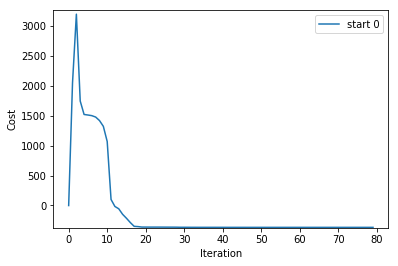

In [9]:
filename = 'deleteme/_rank-0001.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
print(trajectory)
parpe.plotting.plotCostTrajectory(trajectory.T, log=False);

## Compare results

In [10]:
def compareResults(filename, pscale):
    with h5py.File(filename, 'r') as f:
        true_parameters = f['/inputData/parameters/true_parameters'][:]
        expectedNllh = -f['/inputData/parameters/true_llh'][:]
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [11]:
#TODO 
compareResults('deleteme/_rank-0001.h5', model.getParameterScale())

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 -0.053632 -1.053632 -1.053632
1: 0.500000 -0.124944 -0.624944 -1.249888
2: 0.400000 -0.499543 -0.899543 -2.248858
3: 2.000000 0.322648 -1.677352 -0.838676
4: 0.100000 -0.726720 -0.826720 -8.267197
5: 2.000000 0.307566 -1.692434 -0.846217
6: 3.000000 2.988973 -0.011027 -0.003676
7: 0.200000 -0.658891 -0.858891 -4.294454
8: 4.000000 3.987027 -0.012973 -0.003243
Status: 4
Cost: -365.159775 (expected: -0.000000)


In [12]:
!rm sim.h5
!{example_binary_dir}/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Running for start 1
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


In [13]:
with h5py.File('deleteme/_rank-0001.h5', 'r') as f:
    timepoints = f['/inputData/amiciOptions/ts'][:]

with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
    
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[ 0.07291394  0.12432893  0.22693808  0.01959763  0.17132154 -0.09403974
 -0.00778006  0.07413447  0.1479934   0.25346526  0.05256191  0.30647367
  0.17116947  0.31046294  0.24140692  0.60195446  0.47497684  0.65889127
  0.51481292  0.49945552] [0.10001865 0.10003858 0.10007983 0.10016516 0.1003417  0.10070684
 0.10146176 0.1030212  0.10623675 0.11284249 0.12630665 0.15329385
 0.20543289 0.29803288 0.43248337 0.55183725 0.57771499 0.55740092
 0.53745592 0.51742321]
[ 0.16122123  0.28068025  0.10090999 -0.10777344  0.0229079   0.13798564
  0.31839667  0.14001199  0.02341506  0.1912409  -0.07151346  0.15384994
  0.25068305  0.22192178  0.47826362  0.51947216  0.48690076  0.52157708
  0.72118261  0.40725716] [0.10001865 0.10003858 0.10007983 0.10016516 0.1003417  0.10070683
 0.10146172 0.103021   0.10623592 0.11283899 0.12629189 0.15323276
 0.20518956 0.29714365 0.42980275 0.54634468 0.57093159 0.55022544
 0.52910863 0.5084213 ]
[0.10809945 0.04970223 0.05286211 0.15207572 0.09218606 0.01

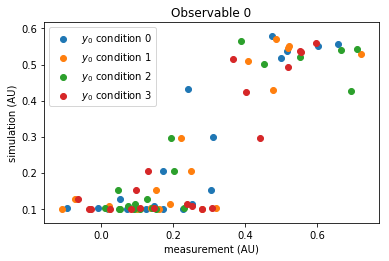

[0.23345774 0.37227836 0.5541289  0.3373294  0.32322673 0.24196411
 0.38617017 0.58904691 0.51577554 0.52736986 0.37882095 0.42528532
 0.35801463 0.50242992 0.74807365 0.59635649 0.60509386 0.64218183
 0.70220528 0.51134212] [0.40001324 0.40002739 0.40005666 0.40011724 0.40024254 0.40050165
 0.40103714 0.40214243 0.40441778 0.40907633 0.41850722 0.43715958
 0.47232085 0.53240846 0.61675368 0.69687469 0.72506623 0.69168441
 0.62478337 0.55575811]
[0.23445213 0.3541172  0.38364756 0.52070876 0.26554988 0.40357661
 0.46142006 0.16023724 0.4589538  0.46171401 0.39382778 0.26901602
 0.44529191 0.54887047 0.58981559 0.60395378 0.76409005 0.66351876
 0.82797926 0.56219776] [0.40001324 0.40002739 0.40005666 0.40011724 0.40024253 0.40050164
 0.4010371  0.40214224 0.40441696 0.40907283 0.41849248 0.43709861
 0.4720775  0.53150375 0.61381254 0.68929859 0.71105067 0.6720649
 0.6006608  0.52991712]
[0.31547464 0.34609986 0.50828489 0.51394393 0.42145968 0.47766822
 0.54808698 0.40024081 0.33467213 

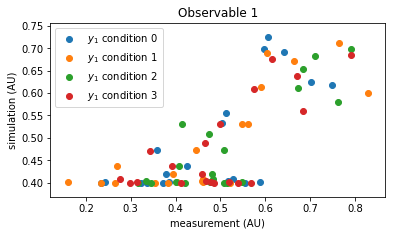

[ 0.6870155   0.50531591  0.76505543  0.6458048   0.70206314  0.91982019
  0.61562151  0.77430481  0.58300972  0.84201204  0.74135865  0.54699954
  0.69070338  0.37725014  0.29870072 -0.0367157   0.01964788  0.07519628
  0.16268716  0.05929642] [0.69997859 0.69995569 0.69990833 0.69981033 0.6996076  0.69918834
 0.69832172 0.69653237 0.69284618 0.68528804 0.66994139 0.63940639
 0.58117291 0.4795749  0.33255519 0.18723343 0.11478216 0.095646
 0.08244132 0.06997181]
[0.74074865 0.85778632 0.7040979  0.51840876 0.80029089 0.67622957
 0.699111   0.84395574 0.71600854 0.71930572 0.78838433 0.72619786
 0.62128183 0.59048232 0.31182081 0.21110808 0.28823001 0.21475357
 0.06380568 0.0955609 ] [0.69997789 0.69995424 0.69990533 0.69980413 0.69959478 0.69916182
 0.69826692 0.69641928 0.69261346 0.68481188 0.66897875 0.63750773
 0.57761283 0.4735462  0.32414845 0.1785995  0.10770092 0.08899392
 0.07565225 0.06351282]
[0.61622565 0.72070858 0.71822158 0.85797854 0.51956068 0.59441179
 0.74174079 0.7

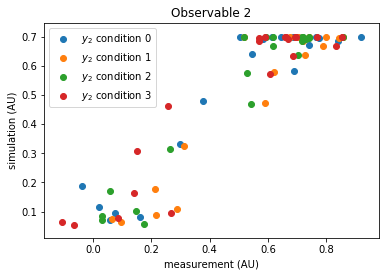

[0.26414961 0.19891925 0.1084861  0.11624213 0.10295806 0.11550639
 0.10137701 0.45107987 0.12393261 0.27829947 0.1720464  0.28657114
 0.57679662 0.63369076 0.84698106 1.1503612  1.20893669 1.19164281
 1.16453511 1.13682278] [0.20307052 0.20311099 0.20319473 0.20336799 0.20372642 0.20446778
 0.20600052 0.20916668 0.2156953  0.22910712 0.25644375 0.31123659
 0.41709585 0.60510408 0.87808248 1.12040985 1.17295011 1.1317059
 1.09121104 1.0505381 ]
[ 0.16407103  0.31166257  0.22584861  0.1647053   0.27114706  0.45620899
  0.13149333  0.07873007  0.15250522 -0.01446676  0.29530112  0.2824888
  0.54877013  0.5309679   0.95153406  0.96112825  1.17240146  1.3509349
  1.1720295   1.10685529] [0.20307052 0.20311099 0.20319473 0.20336799 0.20372642 0.20446776
 0.20600042 0.20916629 0.21569362 0.22910001 0.25641379 0.31111254
 0.41660182 0.60329866 0.87263996 1.10925814 1.1591776  1.11713735
 1.07426332 1.03226128]
[0.22260783 0.26477159 0.09949842 0.16836884 0.24449308 0.0762544
 0.27991802 0.151

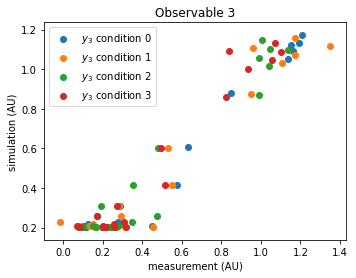

[3.385266   3.40405418 3.46344804 3.30913731 3.44203745 3.42549777
 3.34560847 3.32298719 3.403003   3.55074086 3.44925792 3.50648106
 3.38417972 3.34232407 3.73728644 3.83899241 3.71160091 3.59231059
 3.50216422 3.47541849] [3.38898687 3.38900102 3.3890303  3.38909087 3.38921617 3.38947528
 3.39001078 3.39111607 3.39339142 3.39804997 3.40748085 3.42613322
 3.46129448 3.52138209 3.60572732 3.68584832 3.71403986 3.68065804
 3.613757   3.54473175]
[4.50461077 4.44183264 4.43708248 4.35609902 4.42005846 4.55080215
 4.43006773 4.4303694  4.46068804 4.48682221 4.43905554 4.4959453
 4.49554343 4.39944894 4.64857272 4.61699856 4.67464811 4.65624676
 4.48853864 4.38381294] [4.38704048 4.38705463 4.38708391 4.38714448 4.38726978 4.38752888
 4.38806434 4.38916949 4.39144421 4.39610008 4.40551973 4.42412586
 4.45910475 4.51853099 4.60083978 4.67632583 4.69807792 4.65909215
 4.58768804 4.51694437]
[3.35206481 3.52467348 3.42436012 3.26572286 3.35980662 3.36880685
 3.41272472 3.39223913 3.30975064 

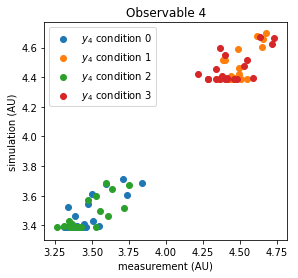

[ 0.10955305  0.17819567 -0.01819027 -0.06043882 -0.22822445 -0.20886816
  0.13172379  0.12075568  0.10069352 -0.1473149   0.03317339 -0.18804071
  0.52265407  0.51171815  0.45281493  0.00826014  0.8037933   0.17430947
  0.91765101  0.37407286] [0.10001865 0.10003858 0.10007983 0.10016516 0.1003417  0.10070684
 0.10146176 0.1030212  0.10623675 0.11284249 0.12630665 0.15329385
 0.20543289 0.29803288 0.43248337 0.55183725 0.57771499 0.55740092
 0.53745592 0.51742321]
[ 0.43678014 -0.04744956 -0.34478193  0.20855439  0.24123848 -0.0773893
  0.10958257 -0.00358257  0.19910664  0.11356348 -0.18790177 -0.05499004
  0.33648561  0.28489053  0.12135855  0.53246389  0.54446831  0.27576591
  0.43550875  0.43957445] [0.10001865 0.10003858 0.10007983 0.10016516 0.1003417  0.10070683
 0.10146172 0.103021   0.10623592 0.11283899 0.12629189 0.15323276
 0.20518956 0.29714365 0.42980275 0.54634468 0.57093159 0.55022544
 0.52910863 0.5084213 ]
[-0.29828311  0.16043396  0.23853711  0.12077855 -0.06363395 

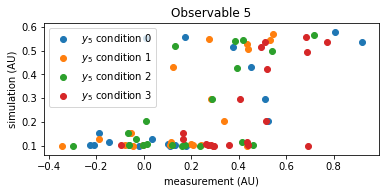

In [14]:
parpe.plotting.plotCorrelation(ymes, ysim)

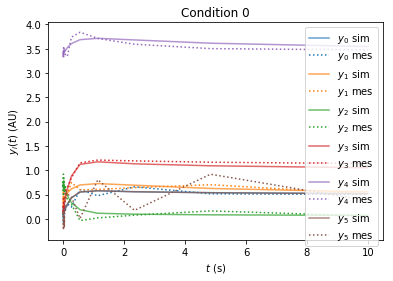

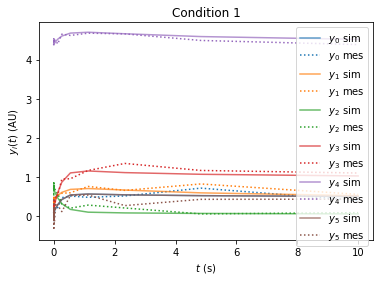

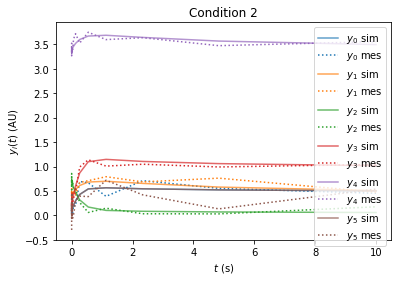

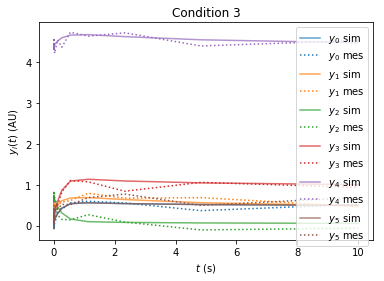

In [16]:
parpe.plotting.plotTrajectoryFit(ymes, ysim, timepoints)

## Hierarchical optimization

In [21]:
hdf5_input_file_hierarchical = f'{example_data_dir}/example_data.h5'
hdf5_pe_output_file_hierarchical = 'deletemehierarchical/_rank00000.h5'
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s hierarchicalOptimization 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s numStarts 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/max_iter 100
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_obj_change_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5_input_file_hierarchical}


                               optimizer            0
                hierarchicalOptimization            1
                               numStarts            1
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
   ipopt/watchdog_shortened_iter_trigger            0
                          ipopt/max_iter          100
         ipopt/acc

In [18]:
# gradient check 
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {hdf5_input_file_hierarchical}


HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-01-11 16:31:11] [INF] [-1/]     0 g:      0.87356  fd_c:     0.873553  Δ/fd_c: 8.385155e-06  f:      708.409
[2019-01-11 16:31:11] [INF] [-1/]     1 g:      828.827  fd_c:      828.827  Δ/fd_c: -2.281936e-08  f:      708.409
[2019-01-11 16:31:11] [INF] [-1/]     2 g:     -9.81181  fd_c:      -9.8118  Δ/fd_c: 1.064142e-06  f:      708.409
[2019-01-11 16:31:11] [WRN] [-1/]     3 g:    -0.821271  fd_c:    -0.821262  Δ/fd_c: 1.089003e-05  f:      708.409
[2019-01-11 16:31:11] [INF] [-1/]     4 g:     -824.772  fd_c:     -824.772  Δ/fd_c: -1.319352e-08  f:      708.409
[2019-01-11 16:31:11] [INF] [-1/] Walltime on master: 0.150566s, CPU time of all processes: 0.355430s


In [20]:
# optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemehierarchical/ {hdf5_input_file_hierarchical}


[2019-01-11 16:32:21] [INF] [0/dweindl] Running with 4 MPI processes.
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-01-11 16:32:21] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
 

[2019-01-11 16:32:23] [INF] [0/dweindl] [o0i22] iter: 22 cost: -365.16 time_iter: wall: 0.0972629s cpu: 0.148558s time_optim: wall: 2.00398s cpu: 3.66234s
  22 -3.6515977e+02 0.00e+00 2.83e-03 -11.0 2.48e-03    -  1.00e+00 6.25e-02f  5
[2019-01-11 16:32:23] [INF] [0/dweindl] [o0i23] iter: 23 cost: -365.16 time_iter: wall: 0.060617s cpu: 0.120493s time_optim: wall: 2.0646s cpu: 3.78284s
  23 -3.6515977e+02 0.00e+00 8.60e-04 -11.0 1.07e-04    -  1.00e+00 1.00e+00f  1
[2019-01-11 16:32:23] [INF] [0/dweindl] [o0i24] iter: 24 cost: -365.16 time_iter: wall: 0.11275s cpu: 0.162355s time_optim: wall: 2.17735s cpu: 3.94519s
  24 -3.6515977e+02 0.00e+00 2.67e-04 -11.0 4.11e-04    -  1.00e+00 1.56e-02f  7
[2019-01-11 16:32:23] [INF] [0/dweindl] [o0i25] iter: 25 cost: -365.16 time_iter: wall: 0.087803s cpu: 0.141786s time_optim: wall: 2.26516s cpu: 4.08698s
  25 -3.6515977e+02 0.00e+00 2.36e-04 -11.0 3.04e-05    -  1.00e+00 2.50e-01f  3
[2019-01-11 16:32:23] [INF] [0/dweindl] [o0i26] iter: 26 cost

array([[-274.38969718, -332.44823062, -357.83373337, -361.22548421,
        -363.53486311, -364.32733492, -364.38257084, -364.56079863,
        -364.79584444, -365.02030979, -365.09682797, -365.10520301,
        -365.13093197, -365.13632269, -365.14799906, -365.15052961,
        -365.15961358, -365.15970459, -365.15973936, -365.15977223,
        -365.15977335, -365.15977441, -365.1597748 , -365.15977498,
        -365.15977498, -365.15977498, -365.15977498, -365.15977498,
        -365.15977498, -365.15977498, -365.15977498]])

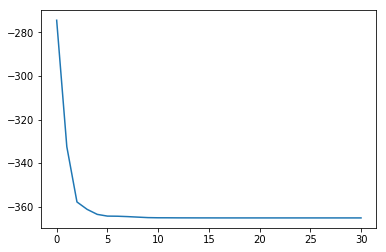

In [22]:
filename = hdf5_pe_output_file_hierarchical
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])    
trajectory

In [26]:
compareResults(hdf5_pe_output_file_hierarchical, model.getParameterScale())

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 -0.053647 -1.053647 -1.053647
1: 0.500000 -0.124937 -0.624937 -1.249873
2: 0.400000 -0.499564 -0.899564 -2.248911
3: 2.000000 0.322650 -1.677350 -0.838675
4: 0.100000 -0.726713 -0.826713 -8.267127
5: 2.000000 0.307566 -1.692434 -0.846217
6: 3.000000 2.988974 -0.011026 -0.003675
7: 0.200000 -0.658892 -0.858892 -4.294459
8: 4.000000 3.987027 -0.012973 -0.003243
Status: 4
Cost: -365.159775 (expected: -0.000000)


In [27]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']

In [28]:
!rm simh.h5
!{example_binary_dir}/example_steadystate_multi_simulator {hdf5_pe_output_file_hierarchical} / simh.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


In [29]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[ 0.07291394  0.12432893  0.22693808  0.01959763  0.17132154 -0.09403974
 -0.00778006  0.07413447  0.1479934   0.25346526  0.05256191  0.30647367
  0.17116947  0.31046294  0.24140692  0.60195446  0.47497684  0.65889127
  0.51481292  0.49945552] [0.10001865 0.10003858 0.10007983 0.10016516 0.1003417  0.10070684
 0.10146176 0.10302119 0.10623674 0.11284247 0.12630659 0.15329372
 0.20543258 0.29803219 0.43248207 0.55183582 0.57771426 0.5574004
 0.53745569 0.51742353]
[ 0.16122123  0.28068025  0.10090999 -0.10777344  0.0229079   0.13798564
  0.31839667  0.14001199  0.02341506  0.1912409  -0.07151346  0.15384994
  0.25068305  0.22192178  0.47826362  0.51947216  0.48690076  0.52157708
  0.72118261  0.40725716] [0.10001865 0.10003858 0.10007983 0.10016516 0.1003417  0.10070683
 0.10146171 0.103021   0.10623591 0.11283896 0.12629183 0.15323262
 0.20518925 0.29714295 0.42980145 0.54634322 0.57093083 0.55022494
 0.52910846 0.50842171]
[0.10809945 0.04970223 0.05286211 0.15207572 0.09218606 0.010

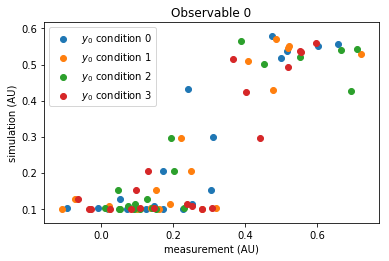

[0.23345774 0.37227836 0.5541289  0.3373294  0.32322673 0.24196411
 0.38617017 0.58904691 0.51577554 0.52736986 0.37882095 0.42528532
 0.35801463 0.50242992 0.74807365 0.59635649 0.60509386 0.64218183
 0.70220528 0.51134212] [0.40001324 0.40002739 0.40005667 0.40011724 0.40024254 0.40050165
 0.40103715 0.40214245 0.40441782 0.4090764  0.41850737 0.43715988
 0.47232143 0.5324095  0.61675517 0.69687576 0.72506598 0.69168356
 0.62478226 0.55575713]
[0.23445213 0.3541172  0.38364756 0.52070876 0.26554988 0.40357661
 0.46142006 0.16023724 0.4589538  0.46171401 0.39382778 0.26901602
 0.44529191 0.54887047 0.58981559 0.60395378 0.76409005 0.66351876
 0.82797926 0.56219776] [0.40001324 0.40002739 0.40005666 0.40011724 0.40024254 0.40050164
 0.40103711 0.40214226 0.404417   0.4090729  0.41849263 0.43709891
 0.47207808 0.53150479 0.61381402 0.68929967 0.71105046 0.67206403
 0.6006596  0.52991603]
[0.31547464 0.34609986 0.50828489 0.51394393 0.42145968 0.47766822
 0.54808698 0.40024081 0.33467213

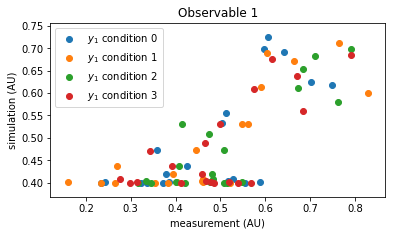

[ 0.6870155   0.50531591  0.76505543  0.6458048   0.70206314  0.91982019
  0.61562151  0.77430481  0.58300972  0.84201204  0.74135865  0.54699954
  0.69070338  0.37725014  0.29870072 -0.0367157   0.01964788  0.07519628
  0.16268716  0.05929642] [0.69997859 0.69995569 0.69990833 0.69981033 0.6996076  0.69918834
 0.69832172 0.69653236 0.69284617 0.68528801 0.66994133 0.63940627
 0.58117269 0.47957459 0.33255496 0.18723379 0.11478327 0.09564719
 0.08244234 0.06997274]
[0.74074865 0.85778632 0.7040979  0.51840876 0.80029089 0.67622957
 0.699111   0.84395574 0.71600854 0.71930572 0.78838433 0.72619786
 0.62128183 0.59048232 0.31182081 0.21110808 0.28823001 0.21475357
 0.06380568 0.0955609 ] [0.69997789 0.69995424 0.69990533 0.69980413 0.69959478 0.69916182
 0.69826692 0.69641928 0.69261344 0.68481185 0.66897869 0.63750761
 0.57761262 0.47354589 0.32414823 0.17859986 0.10770199 0.08899503
 0.07565319 0.06351367]
[0.61622565 0.72070858 0.71822158 0.85797854 0.51956068 0.59441179
 0.74174079 0

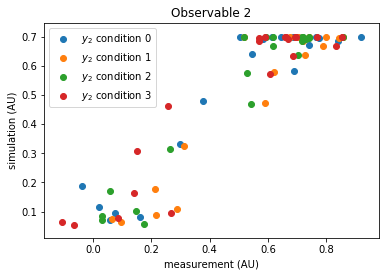

[0.26414961 0.19891925 0.1084861  0.11624213 0.10295806 0.11550639
 0.10137701 0.45107987 0.12393261 0.27829947 0.1720464  0.28657114
 0.57679662 0.63369076 0.84698106 1.1503612  1.20893669 1.19164281
 1.16453511 1.13682278] [0.20307075 0.20311123 0.20319497 0.20336823 0.20372666 0.20446802
 0.20600075 0.20916691 0.21569552 0.22910733 0.25644393 0.31123667
 0.41709571 0.60510338 0.87808087 1.12040826 1.17295    1.13170618
 1.09121186 1.05053998]
[ 0.16407103  0.31166257  0.22584861  0.1647053   0.27114706  0.45620899
  0.13149333  0.07873007  0.15250522 -0.01446676  0.29530112  0.2824888
  0.54877013  0.5309679   0.95153406  0.96112825  1.17240146  1.3509349
  1.1720295   1.10685529] [0.20307075 0.20311123 0.20319497 0.20336823 0.20372666 0.204468
 0.20600066 0.20916652 0.21569385 0.22910022 0.25641396 0.31111263
 0.41660168 0.60329795 0.87263833 1.10925648 1.15917741 1.11713765
 1.07426425 1.03226333]
[0.22260783 0.26477159 0.09949842 0.16836884 0.24449308 0.0762544
 0.27991802 0.1516

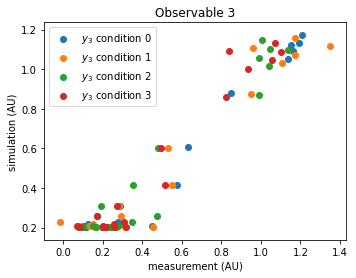

[3.385266   3.40405418 3.46344804 3.30913731 3.44203745 3.42549777
 3.34560847 3.32298719 3.403003   3.55074086 3.44925792 3.50648106
 3.38417972 3.34232407 3.73728644 3.83899241 3.71160091 3.59231059
 3.50216422 3.47541849] [3.3889868  3.38900095 3.38903023 3.3890908  3.3892161  3.38947521
 3.39001072 3.39111601 3.39339138 3.39804997 3.40748093 3.42613344
 3.46129499 3.52138307 3.60572873 3.68584932 3.71403954 3.68065712
 3.61375583 3.54473069]
[4.50461077 4.44183264 4.43708248 4.35609902 4.42005846 4.55080215
 4.43006773 4.4303694  4.46068804 4.48682221 4.43905554 4.4959453
 4.49554343 4.39944894 4.64857272 4.61699856 4.67464811 4.65624676
 4.48853864 4.38381294] [4.38704042 4.38705457 4.38708385 4.38714442 4.38726972 4.38752882
 4.38806429 4.38916944 4.39144418 4.39610008 4.40551981 4.42412609
 4.45910526 4.51853197 4.6008412  4.67632685 4.69807765 4.65909122
 4.58768678 4.51694321]
[3.35206481 3.52467348 3.42436012 3.26572286 3.35980662 3.36880685
 3.41272472 3.39223913 3.30975064 

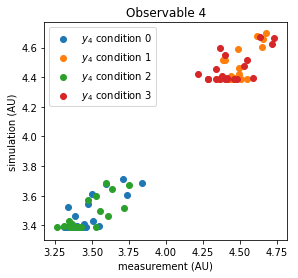

[ 0.10955305  0.17819567 -0.01819027 -0.06043882 -0.22822445 -0.20886816
  0.13172379  0.12075568  0.10069352 -0.1473149   0.03317339 -0.18804071
  0.52265407  0.51171815  0.45281493  0.00826014  0.8037933   0.17430947
  0.91765101  0.37407286] [0.10001865 0.10003858 0.10007983 0.10016516 0.1003417  0.10070684
 0.10146176 0.10302119 0.10623674 0.11284247 0.12630659 0.15329372
 0.20543258 0.29803219 0.43248207 0.55183582 0.57771426 0.5574004
 0.53745569 0.51742353]
[ 0.43678014 -0.04744956 -0.34478193  0.20855439  0.24123848 -0.0773893
  0.10958257 -0.00358257  0.19910664  0.11356348 -0.18790177 -0.05499004
  0.33648561  0.28489053  0.12135855  0.53246389  0.54446831  0.27576591
  0.43550875  0.43957445] [0.10001865 0.10003858 0.10007983 0.10016516 0.1003417  0.10070683
 0.10146171 0.103021   0.10623591 0.11283896 0.12629183 0.15323262
 0.20518925 0.29714295 0.42980145 0.54634322 0.57093083 0.55022494
 0.52910846 0.50842171]
[-0.29828311  0.16043396  0.23853711  0.12077855 -0.06363395 -

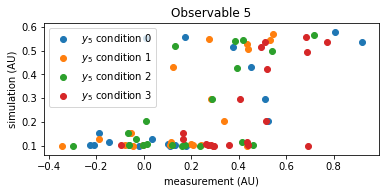

In [31]:
parpe.plotting.plotCorrelation(ymes, ysim)

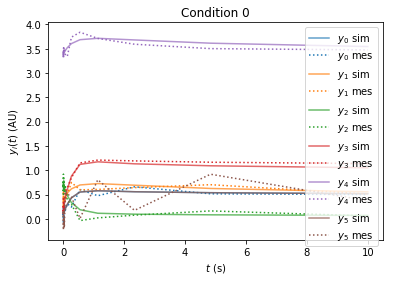

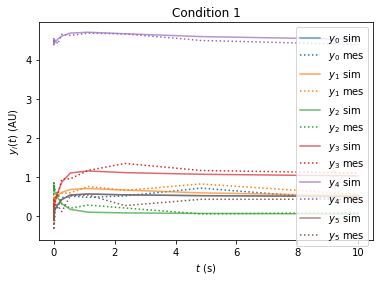

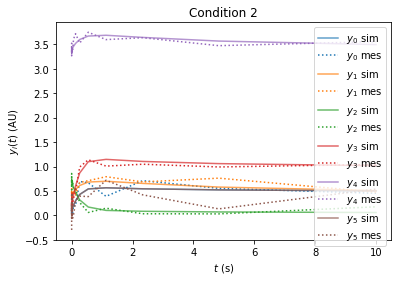

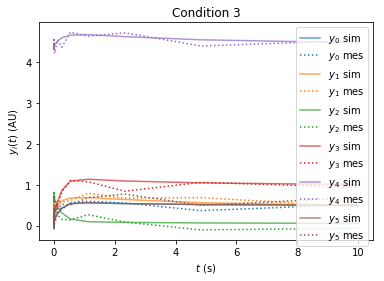

In [32]:
parpe.plotting.plotTrajectoryFit(ymes, ysim, timepoints)

## Ceres

In [36]:
example_data_ceres = f'{example_data_dir}/example_data_ceres.h5'
!cp {example_data_dir}/example_data.h5 {example_data_ceres}
!{optimizationOptionsPy} {example_data_ceres} -s optimizer 1
!mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemeceres/ {example_data_ceres}


[2019-01-11 16:37:00] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2019-01-11 16:37:00] [DBG] [1/dweindl] Seeding RNG with 1547221020
[2019-01-11 16:37:00] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2019-01-11 16:37:00] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2019-01-11 16:37:00] [DBG] [3/dweindl] Seeding RNG with 1547221020
[2019-01-11 16:37:00] [DBG] [2/dweindl] Seeding RNG with 1547221020
[2019-01-11 16:37:00] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-01-11 16:37:00] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2019-01-11 16:37:00] [DBG] [0/dweindl] Seeding RNG with 1547221020
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 propo

[2019-01-11 16:37:01] [DBG] [3/dweindl] [o0i3c2] Result for 29: 89.0278 (0) (0.0223s+)
[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i3c0] Result for 27: 67.8906 (0) (0.0295s+)
[2019-01-11 16:37:01] [DBG] [2/dweindl] [o0i3c1] Result for 28: 80.4208 (0) (0.0287s+)
[2019-01-11 16:37:01] [DBG] [3/dweindl] Message received after waiting 0.000246s.
[2019-01-11 16:37:01] [DBG] [3/dweindl] [o0i3c3] Result for 30: 76.1728 (0) (0.0145s+)
[2019-01-11 16:37:01] [DBG] [3/dweindl] Message received after waiting 0.002166s.
[2019-01-11 16:37:01] [DBG] [3/dweindl] [o0i3c0] Result for 31: -9122.86 (0) (0.0011s-)
[2019-01-11 16:37:01] [DBG] [3/dweindl] [o0i3c1] Result for 31: -16264.9 (0) (0.0012s-)
[2019-01-11 16:37:01] [DBG] [3/dweindl] [o0i3c2] Result for 31: -9065.07 (0) (0.0012s-)
[2019-01-11 16:37:01] [DBG] [1/dweindl] Message received after waiting 0.020207s.
[2019-01-11 16:37:01] [DBG] [2/dweindl] Message received after waiting 0.025625s.
[2019-01-11 16:37:01] [DBG] [3/dweindl] [o0i3c3] Result for 

[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i6c0] Result for 57: 88.1048 (0) (0.0149s+)
[2019-01-11 16:37:01] [DBG] [2/dweindl] [o0i6c1] Result for 58: 89.3163 (0) (0.0155s+)
[2019-01-11 16:37:01] [DBG] [3/dweindl] [o0i6c2] Result for 59: 100.854 (0) (0.0161s+)
[2019-01-11 16:37:01] [DBG] [1/dweindl] Message received after waiting 0.000226s.
[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i6c3] Result for 60: 86.3295 (0) (0.0139s+)
callbacks.cc:105    6: f:-3.646045e+02 d: 1.09e+01 g: 3.32e+01 h: 4.14e-01 s: 3.35e-01 e:  2 it: 1.02e-01 tt: 7.24e-01
[2019-01-11 16:37:01] [INF] [0/dweindl] [o0i6] iter: 6 cost: -364.605 time_iter: wall: 0.102225s cpu: 0.226593s time_optim: wall: 0.725348s cpu: 1.62298s
[2019-01-11 16:37:01] [DBG] [1/dweindl] Message received after waiting 0.001687s.
[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i7c0] Result for 61: -8987.54 (0) (0.0011s-)
[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i7c1] Result for 61: -16098.6 (0) (0.0011s-)
[2019-01-11 16:37:01] [DBG] [1/dweindl]

[2019-01-11 16:37:01] [DBG] [3/dweindl] Message received after waiting 0.000263s.
[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i12c0] Result for 87: 88.0368 (0) (0.0282s+)
[2019-01-11 16:37:01] [DBG] [3/dweindl] [o0i12c3] Result for 90: 86.8088 (0) (0.0156s+)
callbacks.cc:105   12: f:-3.651598e+02 d: 2.72e-05 g: 2.75e-02 h: 9.57e-04 s: 1.00e+00 e:  1 it: 5.80e-02 tt: 1.07e+00
[2019-01-11 16:37:01] [INF] [0/dweindl] [o0i12] iter: 12 cost: -365.16 time_iter: wall: 0.0586021s cpu: 0.134259s time_optim: wall: 1.06829s cpu: 2.35344s
[2019-01-11 16:37:01] [DBG] [1/dweindl] Message received after waiting 0.004151s.
[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i13c0] Result for 91: -8990.49 (0) (0.0014s-)
[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i13c1] Result for 91: -16102.5 (0) (0.0013s-)
[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i13c2] Result for 91: -8939.16 (0) (0.0012s-)
[2019-01-11 16:37:01] [DBG] [1/dweindl] [o0i13c3] Result for 91: -15751.6 (0) (0.0031s-)
[2019-01-11 16:37:01] [DBG] [3

[2019-01-11 16:37:02] [DBG] [0/dweindl] Thread ms #0 finished successfully
[2019-01-11 16:37:03] [DBG] [0/dweindl] runParallelMultiStartOptimization finished
[2019-01-11 16:37:03] [INF] [0/dweindl] Walltime on master: 3.186260s, CPU time of all processes: 9.944295s
[2019-01-11 16:37:03] [INF] [0/dweindl] Sent termination signal to workers.


In [42]:
compareResults('deletemeceres/_rank00000.h5', model.getParameterScale())

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 -0.053647 -1.053647 -1.053647
1: 0.500000 -0.124937 -0.624937 -1.249873
2: 0.400000 -0.499564 -0.899564 -2.248911
3: 2.000000 0.322650 -1.677350 -0.838675
4: 0.100000 -0.726713 -0.826713 -8.267127
5: 2.000000 0.307566 -1.692434 -0.846217
6: 3.000000 2.988974 -0.011026 -0.003675
7: 0.200000 -0.658892 -0.858892 -4.294459
8: 4.000000 3.987027 -0.012973 -0.003243
Status: 0
Cost: -365.159775 (expected: -0.000000)


## Minibatch optimization

In [46]:
hdf5FileMinibatch = f'{example_data_dir}/example_data_minibatch.h5'

!{optimizationOptionsPy} {hdf5FileMinibatch} -s numStarts 1
!{optimizationOptionsPy} {hdf5FileMinibatch} -s hierarchicalOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s optimizer 10 # minibatch
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/maxEpochs 50
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/batchSize 2
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/parameterUpdater Vanilla
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/Vanilla-learningRate 1e-5
!{optimizationOptionsPy} {hdf5FileMinibatch}

                               numStarts            1
                hierarchicalOptimization            0
                       retryOptimization            0
                               optimizer           10
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

In [47]:
!{parpe_source_root}/misc/selectStartingPoints.py {hdf5FileMinibatch} 9 # select starting point

Creating starting point backup in /optimizationOptions/randomStartsBackup
Selecting starting points [9]


In [48]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o deleteme-minibatch/ {hdf5FileMinibatch}

[2019-01-11 16:52:23] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-01-11 16:52:23] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2019-01-11 16:52:23] [DBG] [3/dweindl] Seeding RNG with 1547221943
[2019-01-11 16:52:23] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2019-01-11 16:52:23] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2019-01-11 16:52:23] [DBG] [1/dweindl] Seeding RNG with 1547221943
[2019-01-11 16:52:23] [DBG] [0/dweindl] Seeding RNG with 1547221943
[2019-01-11 16:52:23] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2019-01-11 16:52:23] [DBG] [2/dweindl] Seeding RNG with 1547221943
[2019-01-11 16:52:23] [DBG] [0/dweindl] Starting runParallelMultiStartOptimization with 1 starts
[2019-01-11 16:52:23] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-01-11 16:52:23] [DBG] [0/dweindl] Spawning thread for local optimization #0 (0)
[2019-01-11 16:52:23] [DBG] [0/dweindl] Set optimization option Vanilla-learningRate to 1

[2019-01-11 16:52:23] [DBG] [2/dweindl] [o0e4b0c0] Result for 18: -230.406 (0) (0.0160s+)
[2019-01-11 16:52:23] [DBG] [1/dweindl] [o0e4b0c1] Result for 17: -366.296 (0) (0.0273s+)
[2019-01-11 16:52:23] [DBG] [0/dweindl] [o0e4b0] : p: [ -0.0739653 -0.990287 0.504747 -1.14985 -1.11265 0.152733 3.56864 -0.440422 3.60475 ] Cost: 298.351 Gradient:[ -150.92 -13.5099 180.621 -9.36464 24.8025 -77.6189 409.471 17.7028 -566.06 ] |g|2: 742.101 Batch: [ 1 0 ]

[2019-01-11 16:52:23] [INF] [0/dweindl] [o0e4b0] iter: 8 cost: 298.351 time_iter: wall: 0.0361683s cpu: 0.0433019s time_optim: wall: 0.309869s cpu: 0.338437s
[2019-01-11 16:52:23] [DBG] [1/dweindl] Message received after waiting 0.002004s.
[2019-01-11 16:52:23] [DBG] [2/dweindl] Message received after waiting 0.013913s.
[2019-01-11 16:52:23] [DBG] [2/dweindl] [o0e4b1c2] Result for 20: -236.449 (0) (0.0155s+)
[2019-01-11 16:52:23] [DBG] [1/dweindl] [o0e4b1c3] Result for 19: -325.195 (0) (0.0161s+)
[2019-01-11 16:52:23] [DBG] [0/dweindl] [o0e4

[2019-01-11 16:52:23] [DBG] [2/dweindl] [o0e9b1c3] Result for 40: -270.498 (0) (0.0254s+)
[2019-01-11 16:52:23] [DBG] [0/dweindl] [o0e9b1] : p: [ -0.0562806 -0.988228 0.484855 -1.14926 -1.11666 0.15342 3.52128 -0.442691 3.65662 ] Cost: 286.2 Gradient:[ -205.37 -1.76445 260.413 -17.5074 7.13473 -3.95043 0 23.8991 -977.249 ] |g|2: 1032.45 Batch: [ 1 3 ]

[2019-01-11 16:52:23] [INF] [0/dweindl] [o0e9b1] iter: 19 cost: 286.2 time_iter: wall: 0.048785s cpu: 0.040086s time_optim: wall: 0.673232s cpu: 0.719775s
[2019-01-11 16:52:23] [DBG] [1/dweindl] Message received after waiting 0.025968s.
[2019-01-11 16:52:23] [DBG] [2/dweindl] Message received after waiting 0.007488s.
[2019-01-11 16:52:23] [DBG] [1/dweindl] [o0e10b0c0] Result for 42: -189.558 (0) (0.0137s+)
[2019-01-11 16:52:23] [DBG] [2/dweindl] [o0e10b0c3] Result for 41: -260.292 (0) (0.0226s+)
[2019-01-11 16:52:23] [DBG] [0/dweindl] [o0e10b0] : p: [ -0.0542269 -0.98821 0.482251 -1.14909 -1.11673 0.15346 3.52128 -0.44293 3.66639 ] Cost:

[2019-01-11 16:52:24] [DBG] [2/dweindl] [o0e14b1c0] Result for 59: -166.407 (0) (0.0171s+)
[2019-01-11 16:52:24] [DBG] [1/dweindl] [o0e14b1c2] Result for 60: -172.588 (0) (0.0186s+)
[2019-01-11 16:52:24] [DBG] [0/dweindl] [o0e14b1] : p: [ -0.0401676 -0.987196 0.466304 -1.14816 -1.11872 0.156658 3.49256 -0.444906 3.71214 ] Cost: 169.497 Gradient:[ -102.225 -22.9552 86.8572 -1.78117 40.3282 -66.5942 687.583 19.5071 0 ] |g|2: 705.505 Batch: [ 0 2 ]

[2019-01-11 16:52:24] [INF] [0/dweindl] [o0e14b1] iter: 29 cost: 169.497 time_iter: wall: 0.0336136s cpu: 0.0357365s time_optim: wall: 0.971349s cpu: 1.05854s
[2019-01-11 16:52:24] [DBG] [1/dweindl] Message received after waiting 0.007740s.
[2019-01-11 16:52:24] [DBG] [2/dweindl] Message received after waiting 0.009383s.
[2019-01-11 16:52:24] [DBG] [2/dweindl] [o0e15b0c1] Result for 62: -240.444 (0) (0.0180s+)
[2019-01-11 16:52:24] [DBG] [1/dweindl] [o0e15b0c0] Result for 61: -161.54 (0) (0.0190s+)
[2019-01-11 16:52:24] [DBG] [0/dweindl] [o0e1

[2019-01-11 16:52:24] [DBG] [1/dweindl] Message received after waiting 0.012504s.
[2019-01-11 16:52:24] [DBG] [2/dweindl] Message received after waiting 0.004047s.
[2019-01-11 16:52:24] [DBG] [2/dweindl] [o0e20b0c2] Result for 81: -142.988 (0) (0.0198s+)
[2019-01-11 16:52:24] [DBG] [1/dweindl] [o0e20b0c3] Result for 82: -174.912 (0) (0.0404s+)
[2019-01-11 16:52:24] [DBG] [0/dweindl] [o0e20b0] : p: [ -0.0248841 -0.98601 0.449811 -1.14702 -1.12093 0.162499 3.45337 -0.447328 3.75322 ] Cost: 158.95 Gradient:[ -160.909 -14.8219 168.938 -7.1123 29.4238 31.6095 312.152 24.8975 -364.398 ] |g|2: 536.108 Batch: [ 2 3 ]

[2019-01-11 16:52:24] [INF] [0/dweindl] [o0e20b0] iter: 40 cost: 158.95 time_iter: wall: 0.0525966s cpu: 0.0601592s time_optim: wall: 1.3153s cpu: 1.44722s
[2019-01-11 16:52:24] [DBG] [2/dweindl] Message received after waiting 0.024670s.
[2019-01-11 16:52:24] [DBG] [1/dweindl] Message received after waiting 0.005687s.
[2019-01-11 16:52:24] [DBG] [2/dweindl] [o0e20b1c1] Result for

[2019-01-11 16:52:24] [DBG] [2/dweindl] [o0e25b1c1] Result for 104: -161.185 (0) (0.0150s+)
[2019-01-11 16:52:24] [DBG] [1/dweindl] [o0e25b1c2] Result for 103: -120.345 (0) (0.0233s+)
[2019-01-11 16:52:24] [DBG] [0/dweindl] [o0e25b1] : p: [ -0.0099825 -0.985218 0.43378 -1.14563 -1.12241 0.169052 3.42114 -0.449828 3.7935 ] Cost: 140.765 Gradient:[ -127.582 -3.81503 137.091 -15.287 5.67457 -84.0798 282.102 23.3359 -367.904 ] |g|2: 507.839 Batch: [ 2 1 ]

[2019-01-11 16:52:24] [INF] [0/dweindl] [o0e25b1] iter: 51 cost: 140.765 time_iter: wall: 0.0328211s cpu: 0.0383479s time_optim: wall: 1.71037s cpu: 1.91099s
[2019-01-11 16:52:24] [DBG] [2/dweindl] Message received after waiting 0.011587s.
[2019-01-11 16:52:24] [DBG] [1/dweindl] Message received after waiting 0.002417s.
[2019-01-11 16:52:24] [DBG] [2/dweindl] [o0e26b0c0] Result for 106: -114.38 (0) (0.0147s+)
[2019-01-11 16:52:24] [DBG] [1/dweindl] [o0e26b0c1] Result for 105: -157.933 (0) (0.0351s+)
[2019-01-11 16:52:24] [DBG] [0/dweindl

[2019-01-11 16:52:25] [DBG] [2/dweindl] [o0e31b0c0] Result for 126: -97.9767 (0) (0.0210s+)
[2019-01-11 16:52:25] [DBG] [1/dweindl] [o0e31b0c3] Result for 125: -113.395 (0) (0.0261s+)
[2019-01-11 16:52:25] [DBG] [0/dweindl] [o0e31b0] : p: [ 0.00416599 -0.984685 0.418795 -1.14406 -1.12336 0.176446 3.392 -0.452382 3.82973 ] Cost: 105.686 Gradient:[ -129.445 -5.94854 134.771 -13.0438 11.982 -48.8123 244.371 22.8176 -283.663 ] |g|2: 422.32 Batch: [ 3 0 ]

[2019-01-11 16:52:25] [INF] [0/dweindl] [o0e31b0] iter: 62 cost: 105.686 time_iter: wall: 0.0470435s cpu: 0.0470986s time_optim: wall: 2.15352s cpu: 2.37228s
[2019-01-11 16:52:25] [DBG] [1/dweindl] Message received after waiting 0.007177s.
[2019-01-11 16:52:25] [DBG] [2/dweindl] Message received after waiting 0.015150s.
[2019-01-11 16:52:25] [DBG] [2/dweindl] [o0e31b1c2] Result for 128: -99.9137 (0) (0.0242s+)
[2019-01-11 16:52:25] [DBG] [1/dweindl] [o0e31b1c1] Result for 127: -127.867 (0) (0.0382s+)
[2019-01-11 16:52:25] [DBG] [0/dweindl

[2019-01-11 16:52:25] [DBG] [1/dweindl] [o0e36b0c0] Result for 146: -83.9983 (0) (0.0335s+)
[2019-01-11 16:52:25] [DBG] [2/dweindl] [o0e36b0c3] Result for 145: -93.1473 (0) (0.0333s+)
[2019-01-11 16:52:25] [DBG] [0/dweindl] [o0e36b0] : p: [ 0.0165177 -0.984353 0.405929 -1.14255 -1.12395 0.183281 3.36805 -0.454734 3.85898 ] Cost: 88.5728 Gradient:[ -125.025 -4.60917 128.409 -13.9414 9.39488 -49.2028 222.223 22.891 -252.633 ] |g|2: 385.455 Batch: [ 3 0 ]

[2019-01-11 16:52:25] [INF] [0/dweindl] [o0e36b0] iter: 72 cost: 88.5728 time_iter: wall: 0.0753811s cpu: 0.0667969s time_optim: wall: 2.73798s cpu: 2.95743s
[2019-01-11 16:52:25] [DBG] [2/dweindl] Message received after waiting 0.002855s.
[2019-01-11 16:52:25] [DBG] [1/dweindl] Message received after waiting 0.018674s.
[2019-01-11 16:52:25] [DBG] [2/dweindl] [o0e36b1c1] Result for 147: -105.136 (0) (0.0304s+)
[2019-01-11 16:52:25] [DBG] [1/dweindl] [o0e36b1c2] Result for 148: -85.673 (0) (0.0391s+)
[2019-01-11 16:52:25] [DBG] [0/dweind

[2019-01-11 16:52:26] [DBG] [1/dweindl] [o0e41b0c3] Result for 166: -76.4191 (0) (0.0164s+)
[2019-01-11 16:52:26] [DBG] [2/dweindl] [o0e41b0c1] Result for 165: -87.697 (0) (0.0194s+)
[2019-01-11 16:52:26] [DBG] [0/dweindl] [o0e41b0] : p: [ 0.0284519 -0.984145 0.393668 -1.14096 -1.1243 0.190077 3.34617 -0.457111 3.88531 ] Cost: 82.0581 Gradient:[ -145.908 6.01388 164.2 -21.0551 -9.03153 -48.4642 0 25.9975 -495.075 ] |g|2: 544.918 Batch: [ 1 3 ]

[2019-01-11 16:52:26] [INF] [0/dweindl] [o0e41b0] iter: 82 cost: 82.0581 time_iter: wall: 0.0293987s cpu: 0.035738s time_optim: wall: 3.07791s cpu: 3.3524s
[2019-01-11 16:52:26] [DBG] [1/dweindl] Message received after waiting 0.005478s.
[2019-01-11 16:52:26] [DBG] [2/dweindl] Message received after waiting 0.003417s.
[2019-01-11 16:52:26] [DBG] [2/dweindl] [o0e41b1c2] Result for 167: -74.2731 (0) (0.0177s+)
[2019-01-11 16:52:26] [DBG] [1/dweindl] [o0e41b1c0] Result for 168: -71.7612 (0) (0.0264s+)
[2019-01-11 16:52:26] [DBG] [0/dweindl] [o0e41b

[2019-01-11 16:52:26] [DBG] [2/dweindl] [o0e46b0c3] Result for 185: -62.591 (0) (0.0375s+)
[2019-01-11 16:52:26] [DBG] [0/dweindl] [o0e46b0] : p: [ 0.0399888 -0.984049 0.381976 -1.1393 -1.12444 0.196808 3.32622 -0.45951 3.90895 ] Cost: 67.0179 Gradient:[ -140.048 6.32561 154.952 -21.1659 -9.78104 -47.3503 0 26.123 -444.465 ] |g|2: 494.652 Batch: [ 3 1 ]

[2019-01-11 16:52:26] [INF] [0/dweindl] [o0e46b0] iter: 92 cost: 67.0179 time_iter: wall: 0.050169s cpu: 0.0528702s time_optim: wall: 3.54465s cpu: 3.86754s
[2019-01-11 16:52:26] [DBG] [1/dweindl] Message received after waiting 0.027336s.
[2019-01-11 16:52:26] [DBG] [2/dweindl] Message received after waiting 0.006514s.
[2019-01-11 16:52:26] [DBG] [1/dweindl] [o0e46b1c2] Result for 188: -63.6692 (0) (0.0157s+)
[2019-01-11 16:52:26] [DBG] [2/dweindl] [o0e46b1c0] Result for 187: -61.5195 (0) (0.0256s+)
[2019-01-11 16:52:26] [DBG] [0/dweindl] [o0e46b1] : p: [ 0.0413893 -0.984112 0.380426 -1.13909 -1.12434 0.197281 3.32622 -0.459771 3.9134 

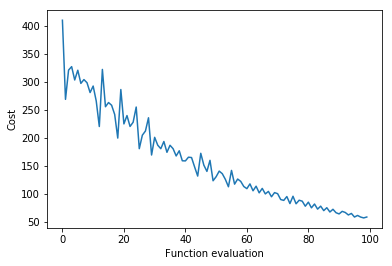

In [49]:
filename = 'deleteme-minibatch/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
    plt.gca().set_xlabel("Function evaluation")
    plt.gca().set_ylabel("Cost")
#trajectory

### Compare learning rates

In [50]:
learningRates = np.logspace(0, -5, 6)
for i, learningRate in enumerate(learningRates):
    curInputFile = "example-data-minibatch-rate-%d.h5" % i
    outprefix = "deleteme-minibatch-rate-%d/" % i
    !cp {hdf5FileMinibatch} {curInputFile}
    !{optimizationOptionsPy} {curInputFile} -s minibatch/Vanilla-learningRate learningRate
    !PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o {outprefix} {hdf5FileMinibatch}

[2019-01-11 16:52:41] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-01-11 16:52:41] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2019-01-11 16:52:41] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2019-01-11 16:52:41] [DBG] [1/dweindl] Seeding RNG with 1547221961
[2019-01-11 16:52:41] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2019-01-11 16:52:41] [DBG] [3/dweindl] Seeding RNG with 1547221961
[2019-01-11 16:52:41] [DBG] [0/dweindl] Seeding RNG with 1547221961
[2019-01-11 16:52:41] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2019-01-11 16:52:41] [DBG] [2/dweindl] Seeding RNG with 1547221961
[2019-01-11 16:52:41] [DBG] [0/dweindl] Starting runParallelMultiStartOptimization with 1 starts
[2019-01-11 16:52:41] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-01-11 16:52:41] [DBG] [0/dweindl] Spawning thread for local optimization #0 (0)
[2019-01-11 16:52:41] [DBG] [0/dweindl] Set optimization option Vanilla-learningRate to 1

[2019-01-11 16:52:41] [DBG] [0/dweindl] [o0e4b0] : p: [ -0.0739547 -0.990284 0.504734 -1.14985 -1.11265 0.152691 3.56864 -0.440421 3.60475 ] Cost: 298.353 Gradient:[ -150.871 -13.4927 180.558 -9.37603 24.7674 -77.819 409.473 17.7039 -566.062 ] |g|2: 742.099 Batch: [ 1 0 ]

[2019-01-11 16:52:41] [INF] [0/dweindl] [o0e4b0] iter: 8 cost: 298.353 time_iter: wall: 0.0397416s cpu: 0.0352119s time_optim: wall: 0.410787s cpu: 0.459439s
[2019-01-11 16:52:41] [DBG] [2/dweindl] Message received after waiting 0.017060s.
[2019-01-11 16:52:41] [DBG] [1/dweindl] Message received after waiting 0.007232s.
[2019-01-11 16:52:41] [DBG] [2/dweindl] [o0e4b1c3] Result for 20: -325.187 (0) (0.0159s+)
[2019-01-11 16:52:41] [DBG] [1/dweindl] [o0e4b1c2] Result for 19: -236.442 (0) (0.0208s+)
[2019-01-11 16:52:41] [DBG] [0/dweindl] [o0e4b1] : p: [ -0.072446 -0.990149 0.502928 -1.14976 -1.1129 0.153469 3.56455 -0.440598 3.61041 ] Cost: 280.815 Gradient:[ -193.601 -26.7602 216.048 0.213184 55.2519 108.586 416.36 23

[2019-01-11 16:52:42] [DBG] [0/dweindl] [o0e9b1] : p: [ -0.0557688 -0.98834 0.484007 -1.14918 -1.11649 0.153044 3.5251 -0.442722 3.66128 ] Cost: 248.582 Gradient:[ -153.111 -12.6218 174.17 -10.0237 23.1515 -45.3553 379.359 20.8861 -506.851 ] |g|2: 676.667 Batch: [ 2 1 ]

[2019-01-11 16:52:42] [INF] [0/dweindl] [o0e9b1] iter: 19 cost: 248.582 time_iter: wall: 0.0371493s cpu: 0.0379955s time_optim: wall: 0.791794s cpu: 0.870037s
[2019-01-11 16:52:42] [DBG] [2/dweindl] Message received after waiting 0.013997s.
[2019-01-11 16:52:42] [DBG] [1/dweindl] Message received after waiting 0.004263s.
[2019-01-11 16:52:42] [DBG] [2/dweindl] [o0e10b0c1] Result for 42: -291.046 (0) (0.0165s+)
[2019-01-11 16:52:42] [DBG] [1/dweindl] [o0e10b0c3] Result for 41: -260.34 (0) (0.0316s+)
[2019-01-11 16:52:42] [DBG] [0/dweindl] [o0e10b0] : p: [ -0.0542377 -0.988213 0.482266 -1.14908 -1.11673 0.153498 3.52131 -0.442931 3.66635 ] Cost: 275.693 Gradient:[ -202.831 -1.38932 256.267 -17.6972 6.31318 -8.42943 0 23.

[2019-01-11 16:52:42] [DBG] [1/dweindl] [o0e14b1c3] Result for 59: -217.332 (0) (0.0265s+)
[2019-01-11 16:52:42] [DBG] [0/dweindl] [o0e14b1] : p: [ -0.0406309 -0.98709 0.467062 -1.14823 -1.11887 0.156992 3.48907 -0.44488 3.70798 ] Cost: 190.715 Gradient:[ -150.658 -13.0069 165.163 -8.45431 26.0818 -25.9549 334.846 22.162 -411.928 ] |g|2: 577.814 Batch: [ 3 0 ]

[2019-01-11 16:52:42] [INF] [0/dweindl] [o0e14b1] iter: 29 cost: 190.715 time_iter: wall: 0.0382374s cpu: 0.0451934s time_optim: wall: 1.16414s cpu: 1.26764s
[2019-01-11 16:52:42] [DBG] [2/dweindl] Message received after waiting 0.010804s.
[2019-01-11 16:52:42] [DBG] [1/dweindl] Message received after waiting 0.005013s.
[2019-01-11 16:52:42] [DBG] [1/dweindl] [o0e15b0c2] Result for 61: -167.61 (0) (0.0155s+)
[2019-01-11 16:52:42] [DBG] [2/dweindl] [o0e15b0c1] Result for 62: -240.485 (0) (0.0287s+)
[2019-01-11 16:52:42] [DBG] [0/dweindl] [o0e15b0] : p: [ -0.0391243 -0.98696 0.46541 -1.14815 -1.11913 0.157251 3.48572 -0.445101 3.7

[2019-01-11 16:52:42] [DBG] [2/dweindl] [o0e20b0c3] Result for 82: -174.855 (0) (0.0212s+)
[2019-01-11 16:52:42] [DBG] [1/dweindl] [o0e20b0c1] Result for 81: -198.68 (0) (0.0336s+)
[2019-01-11 16:52:42] [DBG] [0/dweindl] [o0e20b0] : p: [ -0.0248872 -0.986011 0.449814 -1.14702 -1.12092 0.162515 3.4533 -0.447328 3.7533 ] Cost: 186.768 Gradient:[ -178.369 2.84868 216.73 -19.7735 -2.36909 -38.8431 0 24.9401 -774.6 ] |g|2: 825.426 Batch: [ 1 3 ]

[2019-01-11 16:52:42] [INF] [0/dweindl] [o0e20b0] iter: 40 cost: 186.768 time_iter: wall: 0.0518124s cpu: 0.0547588s time_optim: wall: 1.61503s cpu: 1.74406s
[2019-01-11 16:52:42] [DBG] [1/dweindl] Message received after waiting 0.002229s.
[2019-01-11 16:52:42] [DBG] [2/dweindl] Message received after waiting 0.021192s.
[2019-01-11 16:52:42] [DBG] [2/dweindl] [o0e20b1c2] Result for 84: -142.519 (0) (0.0216s+)
[2019-01-11 16:52:42] [DBG] [1/dweindl] [o0e20b1c0] Result for 83: -137.588 (0) (0.0331s+)
[2019-01-11 16:52:42] [DBG] [0/dweindl] [o0e20b1] 

[2019-01-11 16:52:43] [DBG] [1/dweindl] [o0e25b1c2] Result for 104: -121.762 (0) (0.0172s+)
[2019-01-11 16:52:43] [DBG] [2/dweindl] [o0e25b1c0] Result for 103: -117.613 (0) (0.0186s+)
[2019-01-11 16:52:43] [DBG] [0/dweindl] [o0e25b1] : p: [ -0.00964776 -0.985336 0.4332 -1.14554 -1.1222 0.16904 3.42379 -0.449855 3.79731 ] Cost: 119.688 Gradient:[ -93.9989 -15.7494 79.0611 -6.77903 26.2336 -85.2997 558.993 20.7116 0 ] |g|2: 579.868 Batch: [ 0 2 ]

[2019-01-11 16:52:43] [INF] [0/dweindl] [o0e25b1] iter: 51 cost: 119.688 time_iter: wall: 0.0305917s cpu: 0.0357823s time_optim: wall: 1.96697s cpu: 2.14573s
[2019-01-11 16:52:43] [DBG] [1/dweindl] Message received after waiting 0.006114s.
[2019-01-11 16:52:43] [DBG] [2/dweindl] Message received after waiting 0.003233s.
[2019-01-11 16:52:43] [DBG] [1/dweindl] [o0e26b0c0] Result for 106: -114.316 (0) (0.0167s+)
[2019-01-11 16:52:43] [DBG] [2/dweindl] [o0e26b0c1] Result for 105: -157.83 (0) (0.0169s+)
[2019-01-11 16:52:43] [DBG] [0/dweindl] [o0e2

[2019-01-11 16:52:43] [DBG] [2/dweindl] [o0e30b1c3] Result for 124: -115.475 (0) (0.0192s+)
[2019-01-11 16:52:43] [DBG] [1/dweindl] [o0e30b1c0] Result for 123: -99.3916 (0) (0.0193s+)
[2019-01-11 16:52:43] [DBG] [0/dweindl] [o0e30b1] : p: [ 0.00285302 -0.98475 0.420165 -1.14419 -1.12323 0.176005 3.39436 -0.452153 3.82699 ] Cost: 107.433 Gradient:[ -130.177 -6.18557 135.768 -12.8924 12.437 -47.6816 246.542 22.8051 -286.594 ] |g|2: 425.97 Batch: [ 0 3 ]

[2019-01-11 16:52:43] [INF] [0/dweindl] [o0e30b1] iter: 61 cost: 107.433 time_iter: wall: 0.0306265s cpu: 0.0384335s time_optim: wall: 2.33259s cpu: 2.53191s
[2019-01-11 16:52:43] [DBG] [1/dweindl] Message received after waiting 0.002634s.
[2019-01-11 16:52:43] [DBG] [2/dweindl] Message received after waiting 0.003699s.
[2019-01-11 16:52:43] [DBG] [1/dweindl] [o0e31b0c2] Result for 125: -101.393 (0) (0.0149s+)
[2019-01-11 16:52:43] [DBG] [2/dweindl] [o0e31b0c3] Result for 126: -113.332 (0) (0.0176s+)
[2019-01-11 16:52:43] [DBG] [0/dweind

[2019-01-11 16:52:44] [DBG] [1/dweindl] [o0e35b1c0] Result for 143: -85.3391 (0) (0.0182s+)
[2019-01-11 16:52:44] [DBG] [2/dweindl] [o0e35b1c1] Result for 144: -109.356 (0) (0.0244s+)
[2019-01-11 16:52:44] [DBG] [0/dweindl] [o0e35b1] : p: [ 0.0155257 -0.984316 0.407004 -1.14276 -1.12403 0.181752 3.3702 -0.454517 3.85608 ] Cost: 97.3478 Gradient:[ -96.9419 4.32068 104.838 -20.788 -9.59639 -160.44 224.215 21.5949 -301.611 ] |g|2: 434.028 Batch: [ 0 1 ]

[2019-01-11 16:52:44] [INF] [0/dweindl] [o0e35b1] iter: 71 cost: 97.3478 time_iter: wall: 0.0462825s cpu: 0.0425714s time_optim: wall: 2.76528s cpu: 2.99044s
[2019-01-11 16:52:44] [DBG] [1/dweindl] Message received after waiting 0.011244s.
[2019-01-11 16:52:44] [DBG] [2/dweindl] Message received after waiting 0.014208s.
[2019-01-11 16:52:44] [DBG] [1/dweindl] [o0e36b0c0] Result for 145: -83.9481 (0) (0.0373s+)
[2019-01-11 16:52:44] [DBG] [2/dweindl] [o0e36b0c3] Result for 146: -93.1052 (0) (0.0272s+)
[2019-01-11 16:52:44] [DBG] [0/dweindl

[2019-01-11 16:52:44] [DBG] [1/dweindl] Message received after waiting 0.008521s.
[2019-01-11 16:52:44] [DBG] [2/dweindl] [o0e41b0c0] Result for 166: -72.0228 (0) (0.0243s+)
[2019-01-11 16:52:44] [DBG] [1/dweindl] [o0e41b0c3] Result for 165: -76.3965 (0) (0.0298s+)
[2019-01-11 16:52:44] [DBG] [0/dweindl] [o0e41b0] : p: [ 0.0284552 -0.984142 0.393664 -1.14096 -1.1243 0.190057 3.34613 -0.45711 3.88536 ] Cost: 74.2096 Gradient:[ -120.96 -3.43257 122.612 -14.7438 7.14255 -48.832 202.045 22.9218 -224.541 ] |g|2: 352.273 Batch: [ 3 0 ]

[2019-01-11 16:52:44] [INF] [0/dweindl] [o0e41b0] iter: 82 cost: 74.2096 time_iter: wall: 0.0564305s cpu: 0.054128s time_optim: wall: 3.31807s cpu: 3.55855s
[2019-01-11 16:52:44] [DBG] [1/dweindl] Message received after waiting 0.002977s.
[2019-01-11 16:52:44] [DBG] [2/dweindl] Message received after waiting 0.023905s.
[2019-01-11 16:52:44] [DBG] [2/dweindl] [o0e41b1c1] Result for 168: -86.0686 (0) (0.0215s+)
[2019-01-11 16:52:44] [DBG] [1/dweindl] [o0e41b1c2

[2019-01-11 16:52:45] [DBG] [0/dweindl] [o0e46b0] : p: [ 0.0399895 -0.984047 0.381974 -1.1393 -1.12444 0.196802 3.32616 -0.459509 3.90902 ] Cost: 67.6811 Gradient:[ -109.52 1.57532 110.828 -18.5299 -4.41664 -85.3455 194.361 25.2465 -245.108 ] |g|2: 361.135 Batch: [ 2 1 ]

[2019-01-11 16:52:45] [INF] [0/dweindl] [o0e46b0] iter: 92 cost: 67.6811 time_iter: wall: 0.0476358s cpu: 0.0464396s time_optim: wall: 3.8051s cpu: 4.08583s
[2019-01-11 16:52:45] [DBG] [1/dweindl] Message received after waiting 0.002798s.
[2019-01-11 16:52:45] [DBG] [2/dweindl] Message received after waiting 0.022757s.
[2019-01-11 16:52:45] [DBG] [2/dweindl] [o0e46b1c0] Result for 188: -60.7737 (0) (0.0194s+)
[2019-01-11 16:52:45] [DBG] [1/dweindl] [o0e46b1c3] Result for 187: -61.2533 (0) (0.0336s+)
[2019-01-11 16:52:45] [DBG] [0/dweindl] [o0e46b1] : p: [ 0.0410847 -0.984063 0.380866 -1.13911 -1.1244 0.197655 3.32422 -0.459762 3.91147 ] Cost: 61.0135 Gradient:[ -117.13 -2.39515 117.147 -15.4772 5.16176 -46.6768 181.97

[2019-01-11 16:52:48] [DBG] [1/dweindl] [o0e0b0c0] Result for 1: -263.322 (0) (0.0219s+)
[2019-01-11 16:52:48] [DBG] [2/dweindl] [o0e0b0c3] Result for 2: -391.603 (0) (0.0459s+)
[2019-01-11 16:52:48] [DBG] [0/dweindl] [o0e0b0] : p: [ -0.0884412 -0.992155 0.521594 -1.15005 -1.10888 0.156054 3.60332 -0.438819 3.55912 ] Cost: 327.463 Gradient:[ -192.687 -28.1989 223.81 1.47917 58.8404 88.0805 442.009 20.6858 -567.798 ] |g|2: 785.768 Batch: [ 0 3 ]

[2019-01-11 16:52:48] [INF] [0/dweindl] [o0e0b0] iter: 0 cost: 327.463 time_iter: wall: 0.0782034s cpu: 0.0678758s time_optim: wall: 0.078204s cpu: 0.0678758s
[2019-01-11 16:52:48] [DBG] [1/dweindl] Message received after waiting 0.041512s.
[2019-01-11 16:52:48] [DBG] [2/dweindl] Message received after waiting 0.003475s.
[2019-01-11 16:52:48] [DBG] [1/dweindl] [o0e0b1c2] Result for 3: -270.852 (0) (0.0148s+)
[2019-01-11 16:52:48] [DBG] [2/dweindl] [o0e0b1c1] Result for 4: -419.83 (0) (0.0285s+)
[2019-01-11 16:52:48] [DBG] [0/dweindl] [o0e0b1] :

[2019-01-11 16:52:48] [DBG] [2/dweindl] [o0e5b0c3] Result for 22: -318.601 (0) (0.0371s+)
[2019-01-11 16:52:48] [DBG] [0/dweindl] [o0e5b0] : p: [ -0.0705092 -0.989882 0.500766 -1.14976 -1.11345 0.15239 3.56039 -0.44083 3.61555 ] Cost: 335.538 Gradient:[ -220.152 -5.29512 283.662 -15.595 14.47 25.7235 0 23.3151 -1063.48 ] |g|2: 1123.22 Batch: [ 1 3 ]

[2019-01-11 16:52:48] [INF] [0/dweindl] [o0e5b0] iter: 10 cost: 335.538 time_iter: wall: 0.0561925s cpu: 0.0532885s time_optim: wall: 0.65435s cpu: 0.593479s
[2019-01-11 16:52:48] [DBG] [1/dweindl] Message received after waiting 0.033442s.
[2019-01-11 16:52:48] [DBG] [2/dweindl] Message received after waiting 0.004101s.
[2019-01-11 16:52:48] [DBG] [1/dweindl] [o0e5b1c0] Result for 24: -222.519 (0) (0.0149s+)
[2019-01-11 16:52:48] [DBG] [2/dweindl] [o0e5b1c2] Result for 23: -231.678 (0) (0.0330s+)
[2019-01-11 16:52:48] [DBG] [0/dweindl] [o0e5b1] : p: [ -0.0683076 -0.98983 0.49793 -1.1496 -1.1136 0.152133 3.56039 -0.441064 3.62619 ] Cost: 22

[2019-01-11 16:52:49] [DBG] [1/dweindl] [o0e10b1c0] Result for 44: -189.122 (0) (0.0260s+)
[2019-01-11 16:52:49] [DBG] [2/dweindl] [o0e10b1c2] Result for 43: -196.403 (0) (0.0331s+)
[2019-01-11 16:52:49] [DBG] [0/dweindl] [o0e10b1] : p: [ -0.0522187 -0.988201 0.479714 -1.1489 -1.11678 0.153607 3.52123 -0.443171 3.67601 ] Cost: 192.763 Gradient:[ -107.061 -26.4482 91.8416 0.642695 47.4736 -51.694 741.371 18.9386 0 ] |g|2: 758.625 Batch: [ 2 0 ]

[2019-01-11 16:52:49] [INF] [0/dweindl] [o0e10b1] iter: 21 cost: 192.763 time_iter: wall: 0.0459045s cpu: 0.0591509s time_optim: wall: 1.20093s cpu: 1.17436s
[2019-01-11 16:52:49] [DBG] [1/dweindl] Message received after waiting 0.012605s.
[2019-01-11 16:52:49] [DBG] [2/dweindl] Message received after waiting 0.005232s.
[2019-01-11 16:52:49] [DBG] [1/dweindl] [o0e11b0c2] Result for 46: -190.619 (0) (0.0155s+)
[2019-01-11 16:52:49] [DBG] [2/dweindl] [o0e11b0c0] Result for 45: -183.504 (0) (0.0381s+)
[2019-01-11 16:52:49] [DBG] [0/dweindl] [o0e11b

[2019-01-11 16:52:49] [DBG] [2/dweindl] [o0e15b1c0] Result for 64: -161.153 (0) (0.0159s+)
[2019-01-11 16:52:49] [DBG] [1/dweindl] [o0e15b1c2] Result for 63: -167.087 (0) (0.0308s+)
[2019-01-11 16:52:49] [DBG] [0/dweindl] [o0e15b1] : p: [ -0.0372355 -0.986971 0.463069 -1.14796 -1.11914 0.157536 3.48565 -0.445346 3.72079 ] Cost: 164.12 Gradient:[ -101.173 -22.1526 85.7979 -2.33677 38.7158 -69.6327 674.618 19.6375 0 ] |g|2: 692.774 Batch: [ 2 0 ]

[2019-01-11 16:52:49] [INF] [0/dweindl] [o0e15b1] iter: 31 cost: 164.12 time_iter: wall: 0.0421002s cpu: 0.0467509s time_optim: wall: 1.59599s cpu: 1.60886s
[2019-01-11 16:52:49] [DBG] [2/dweindl] Message received after waiting 0.016066s.
[2019-01-11 16:52:49] [DBG] [1/dweindl] Message received after waiting 0.013695s.
[2019-01-11 16:52:49] [DBG] [2/dweindl] [o0e16b0c0] Result for 66: -156.459 (0) (0.0153s+)
[2019-01-11 16:52:49] [DBG] [1/dweindl] [o0e16b0c2] Result for 65: -162.272 (0) (0.0154s+)
[2019-01-11 16:52:49] [DBG] [0/dweindl] [o0e16b

[2019-01-11 16:52:50] [DBG] [2/dweindl] [o0e20b1c3] Result for 84: -171.238 (0) (0.0460s+)
[2019-01-11 16:52:50] [DBG] [0/dweindl] [o0e20b1] : p: [ -0.023531 -0.985946 0.448326 -1.14688 -1.12103 0.163246 3.45012 -0.447554 3.75748 ] Cost: 153.47 Gradient:[ -141.451 -9.84849 152 -10.4965 19.6689 -39.453 298.419 22.4865 -359.937 ] |g|2: 514.176 Batch: [ 0 3 ]

[2019-01-11 16:52:50] [INF] [0/dweindl] [o0e20b1] iter: 41 cost: 153.47 time_iter: wall: 0.0702816s cpu: 0.0617102s time_optim: wall: 2.28288s cpu: 2.19613s
[2019-01-11 16:52:50] [DBG] [2/dweindl] Message received after waiting 0.002793s.
[2019-01-11 16:52:50] [DBG] [1/dweindl] Message received after waiting 0.047472s.
[2019-01-11 16:52:50] [DBG] [1/dweindl] [o0e21b0c3] Result for 85: -168.031 (0) (0.0183s+)
[2019-01-11 16:52:50] [DBG] [2/dweindl] [o0e21b0c1] Result for 86: -191.185 (0) (0.0327s+)
[2019-01-11 16:52:50] [DBG] [0/dweindl] [o0e21b0] : p: [ -0.0221165 -0.985848 0.446806 -1.14678 -1.12123 0.16364 3.44713 -0.447779 3.7610

[2019-01-11 16:52:51] [DBG] [0/dweindl] [o0e25b1] : p: [ -0.0102535 -0.985305 0.434004 -1.14556 -1.12221 0.170145 3.42106 -0.449809 3.79406 ] Cost: 130.537 Gradient:[ -155.545 -12.926 160.697 -8.2738 25.4622 28.8665 281.988 25.2391 -321.413 ] |g|2: 484.969 Batch: [ 2 3 ]

[2019-01-11 16:52:51] [INF] [0/dweindl] [o0e25b1] iter: 51 cost: 130.537 time_iter: wall: 0.0501659s cpu: 0.0477418s time_optim: wall: 2.82151s cpu: 2.73042s
[2019-01-11 16:52:51] [DBG] [2/dweindl] Message received after waiting 0.002446s.
[2019-01-11 16:52:51] [DBG] [1/dweindl] Message received after waiting 0.023507s.
[2019-01-11 16:52:51] [DBG] [1/dweindl] [o0e26b0c0] Result for 105: -114.337 (0) (0.0184s+)
[2019-01-11 16:52:51] [DBG] [2/dweindl] [o0e26b0c2] Result for 106: -118.412 (0) (0.0317s+)
[2019-01-11 16:52:51] [DBG] [0/dweindl] [o0e26b0] : p: [ -0.00869808 -0.985176 0.432397 -1.14548 -1.12247 0.169857 3.41824 -0.450062 3.79728 ] Cost: 116.375 Gradient:[ -94.5023 -15.5135 79.9774 -6.94964 25.8284 -84.2144 5

[2019-01-11 16:52:51] [DBG] [2/dweindl] [o0e31b0c0] Result for 126: -97.9182 (0) (0.0201s+)
[2019-01-11 16:52:51] [DBG] [1/dweindl] [o0e31b0c2] Result for 125: -101.395 (0) (0.0256s+)
[2019-01-11 16:52:51] [DBG] [0/dweindl] [o0e31b0] : p: [ 0.00414653 -0.98469 0.418817 -1.14406 -1.12335 0.176509 3.3919 -0.452382 3.82986 ] Cost: 99.6566 Gradient:[ -92.1681 -13.0472 77.949 -8.66965 21.2142 -86.4323 499.176 21.148 0 ] |g|2: 521.882 Batch: [ 2 0 ]

[2019-01-11 16:52:51] [INF] [0/dweindl] [o0e31b0] iter: 62 cost: 99.6566 time_iter: wall: 0.0514212s cpu: 0.0457532s time_optim: wall: 3.41619s cpu: 3.36844s
[2019-01-11 16:52:51] [DBG] [2/dweindl] Message received after waiting 0.021689s.
[2019-01-11 16:52:51] [DBG] [1/dweindl] Message received after waiting 0.003903s.
[2019-01-11 16:52:51] [DBG] [2/dweindl] [o0e31b1c1] Result for 128: -129.726 (0) (0.0213s+)
[2019-01-11 16:52:51] [DBG] [1/dweindl] [o0e31b1c3] Result for 127: -113.042 (0) (0.0301s+)
[2019-01-11 16:52:51] [DBG] [0/dweindl] [o0e3

[2019-01-11 16:52:52] [DBG] [1/dweindl] [o0e36b1c2] Result for 147: -85.6523 (0) (0.0155s+)
[2019-01-11 16:52:52] [DBG] [2/dweindl] [o0e36b1c3] Result for 148: -91.2702 (0) (0.0213s+)
[2019-01-11 16:52:52] [DBG] [0/dweindl] [o0e36b1] : p: [ 0.0174898 -0.984395 0.404876 -1.14235 -1.12385 0.184856 3.36569 -0.454949 3.86213 ] Cost: 88.4613 Gradient:[ -145.757 -9.64623 146.058 -10.2925 18.8213 25.0574 230.65 25.7174 -249.33 ] |g|2: 399.732 Batch: [ 2 3 ]

[2019-01-11 16:52:52] [INF] [0/dweindl] [o0e36b1] iter: 73 cost: 88.4613 time_iter: wall: 0.0322232s cpu: 0.0368483s time_optim: wall: 3.93889s cpu: 3.94236s
[2019-01-11 16:52:52] [DBG] [2/dweindl] Message received after waiting 0.002502s.
[2019-01-11 16:52:52] [DBG] [1/dweindl] Message received after waiting 0.008658s.
[2019-01-11 16:52:52] [DBG] [1/dweindl] [o0e37b0c2] Result for 149: -84.2858 (0) (0.0158s+)
[2019-01-11 16:52:52] [DBG] [2/dweindl] [o0e37b0c3] Result for 150: -89.4588 (0) (0.0200s+)
[2019-01-11 16:52:52] [DBG] [0/dweindl

[2019-01-11 16:52:52] [DBG] [1/dweindl] [o0e41b1c1] Result for 167: -86.0848 (0) (0.0268s+)
[2019-01-11 16:52:52] [DBG] [0/dweindl] [o0e41b1] : p: [ 0.0298841 -0.984056 0.392245 -1.14085 -1.12447 0.189799 3.34392 -0.457368 3.8877 ] Cost: 78.5392 Gradient:[ -91.4353 5.79617 97.1674 -21.76 -12.2304 -160.347 200.039 21.9783 -267.902 ] |g|2: 395.525 Batch: [ 1 0 ]

[2019-01-11 16:52:52] [INF] [0/dweindl] [o0e41b1] iter: 83 cost: 78.5392 time_iter: wall: 0.0371127s cpu: 0.0455944s time_optim: wall: 4.28056s cpu: 4.32682s
[2019-01-11 16:52:52] [DBG] [1/dweindl] Message received after waiting 0.002900s.
[2019-01-11 16:52:52] [DBG] [2/dweindl] Message received after waiting 0.007471s.
[2019-01-11 16:52:52] [DBG] [1/dweindl] [o0e42b0c0] Result for 169: -69.8192 (0) (0.0152s+)
[2019-01-11 16:52:52] [DBG] [2/dweindl] [o0e42b0c3] Result for 170: -73.3758 (0) (0.0182s+)
[2019-01-11 16:52:52] [DBG] [0/dweindl] [o0e42b0] : p: [ 0.0307985 -0.984114 0.391273 -1.14064 -1.12435 0.191402 3.34192 -0.457588

[2019-01-11 16:52:52] [DBG] [2/dweindl] [o0e46b1c3] Result for 188: -61.2329 (0) (0.0171s+)
[2019-01-11 16:52:52] [DBG] [1/dweindl] [o0e46b1c0] Result for 187: -60.7655 (0) (0.0197s+)
[2019-01-11 16:52:52] [DBG] [0/dweindl] [o0e46b1] : p: [ 0.0410928 -0.984062 0.380854 -1.13911 -1.1244 0.197634 3.32419 -0.459761 3.91151 ] Cost: 60.9992 Gradient:[ -117.1 -2.38628 117.109 -15.4827 5.14526 -46.7799 181.951 22.9091 -196.568 ] |g|2: 319.62 Batch: [ 0 3 ]

[2019-01-11 16:52:52] [INF] [0/dweindl] [o0e46b1] iter: 93 cost: 60.9992 time_iter: wall: 0.0317982s cpu: 0.0368047s time_optim: wall: 4.61621s cpu: 4.69854s
[2019-01-11 16:52:52] [DBG] [2/dweindl] Message received after waiting 0.006287s.
[2019-01-11 16:52:52] [DBG] [1/dweindl] Message received after waiting 0.005122s.
[2019-01-11 16:52:52] [DBG] [2/dweindl] [o0e47b0c0] Result for 190: -59.8845 (0) (0.0163s+)
[2019-01-11 16:52:52] [DBG] [1/dweindl] [o0e47b0c1] Result for 189: -68.4757 (0) (0.0170s+)
[2019-01-11 16:52:52] [DBG] [0/dweindl]

[2019-01-11 16:52:55] [DBG] [0/dweindl] [o0e0b1] : p: [ -0.0865143 -0.991873 0.519356 -1.15007 -1.10947 0.155173 3.5989 -0.439026 3.5648 ] Cost: 345.341 Gradient:[ -182.711 -23.4235 216.022 -3.28489 46.1393 38.8955 448.634 18.7616 -607.873 ] |g|2: 809.558 Batch: [ 1 2 ]

[2019-01-11 16:52:55] [INF] [0/dweindl] [o0e0b1] iter: 1 cost: 345.341 time_iter: wall: 0.0268542s cpu: 0.0337727s time_optim: wall: 0.0579328s cpu: 0.0735619s
[2019-01-11 16:52:55] [DBG] [1/dweindl] Message received after waiting 0.001910s.
[2019-01-11 16:52:55] [DBG] [2/dweindl] Message received after waiting 0.003279s.
[2019-01-11 16:52:55] [DBG] [2/dweindl] [o0e1b0c0] Result for 6: -254.59 (0) (0.0162s+)
[2019-01-11 16:52:55] [DBG] [1/dweindl] [o0e1b0c3] Result for 5: -375.594 (0) (0.0176s+)
[2019-01-11 16:52:55] [DBG] [0/dweindl] [o0e1b0] : p: [ -0.0846872 -0.991639 0.517196 -1.15003 -1.10993 0.154784 3.59442 -0.439213 3.57088 ] Cost: 315.092 Gradient:[ -187.945 -26.4558 217.295 0.323032 54.95 72.1114 433.659 20.8

[2019-01-11 16:52:55] [DBG] [1/dweindl] [o0e6b0c2] Result for 25: -224.679 (0) (0.0157s+)
[2019-01-11 16:52:55] [DBG] [0/dweindl] [o0e6b0] : p: [ -0.0671108 -0.989498 0.496867 -1.14966 -1.11422 0.152201 3.55225 -0.441243 3.62618 ] Cost: 281.912 Gradient:[ -162.341 -15.96 187.322 -7.97593 30.0924 -22.4313 404.834 20.1545 -543.62 ] |g|2: 723.181 Batch: [ 2 1 ]

[2019-01-11 16:52:55] [INF] [0/dweindl] [o0e6b0] iter: 12 cost: 281.912 time_iter: wall: 0.0506095s cpu: 0.0314909s time_optim: wall: 0.483839s cpu: 0.523601s
[2019-01-11 16:52:55] [DBG] [1/dweindl] Message received after waiting 0.006343s.
[2019-01-11 16:52:55] [DBG] [2/dweindl] Message received after waiting 0.028400s.
[2019-01-11 16:52:55] [DBG] [1/dweindl] [o0e6b1c0] Result for 27: -212.242 (0) (0.0249s+)
[2019-01-11 16:52:55] [DBG] [2/dweindl] [o0e6b1c3] Result for 28: -299.522 (0) (0.0387s+)
[2019-01-11 16:52:55] [DBG] [0/dweindl] [o0e6b1] : p: [ -0.0654874 -0.989338 0.494994 -1.14958 -1.11452 0.152426 3.5482 -0.441445 3.631

[2019-01-11 16:52:56] [DBG] [1/dweindl] [o0e11b1c3] Result for 48: -249.614 (0) (0.0264s+)
[2019-01-11 16:52:56] [DBG] [2/dweindl] [o0e11b1c1] Result for 47: -279.661 (0) (0.0394s+)
[2019-01-11 16:52:56] [DBG] [0/dweindl] [o0e11b1] : p: [ -0.0500409 -0.987669 0.477827 -1.14892 -1.11775 0.154541 3.50664 -0.443548 3.67591 ] Cost: 264.638 Gradient:[ -199.397 -0.551201 250.852 -18.136 4.63151 -13.8371 0 24.1331 -936.836 ] |g|2: 990.692 Batch: [ 1 3 ]

[2019-01-11 16:52:56] [INF] [0/dweindl] [o0e11b1] iter: 23 cost: 264.638 time_iter: wall: 0.0645997s cpu: 0.0657438s time_optim: wall: 1.10142s cpu: 1.22945s
[2019-01-11 16:52:56] [DBG] [1/dweindl] Message received after waiting 0.031790s.
[2019-01-11 16:52:56] [DBG] [2/dweindl] Message received after waiting 0.005432s.
[2019-01-11 16:52:56] [DBG] [1/dweindl] [o0e12b0c3] Result for 50: -240.24 (0) (0.0169s+)
[2019-01-11 16:52:56] [DBG] [2/dweindl] [o0e12b0c0] Result for 49: -177.774 (0) (0.0368s+)
[2019-01-11 16:52:56] [DBG] [0/dweindl] [o0e1

[2019-01-11 16:52:56] [DBG] [2/dweindl] [o0e16b1c1] Result for 67: -227.406 (0) (0.0177s+)
[2019-01-11 16:52:56] [DBG] [1/dweindl] [o0e16b1c0] Result for 68: -154.144 (0) (0.0228s+)
[2019-01-11 16:52:56] [DBG] [0/dweindl] [o0e16b1] : p: [ -0.034537 -0.986578 0.460412 -1.14788 -1.11988 0.157781 3.47566 -0.445786 3.72464 ] Cost: 190.775 Gradient:[ -120.177 -2.80505 137.708 -16.2558 3.51697 -145.093 322.325 19.7742 -440.367 ] |g|2: 594.097 Batch: [ 1 0 ]

[2019-01-11 16:52:56] [INF] [0/dweindl] [o0e16b1] iter: 33 cost: 190.775 time_iter: wall: 0.0431628s cpu: 0.0404669s time_optim: wall: 1.48833s cpu: 1.64858s
[2019-01-11 16:52:56] [DBG] [2/dweindl] Message received after waiting 0.018290s.
[2019-01-11 16:52:56] [DBG] [1/dweindl] Message received after waiting 0.007976s.
[2019-01-11 16:52:56] [DBG] [2/dweindl] [o0e17b0c3] Result for 70: -196.971 (0) (0.0239s+)
[2019-01-11 16:52:56] [DBG] [1/dweindl] [o0e17b0c0] Result for 69: -151.668 (0) (0.0211s+)
[2019-01-11 16:52:56] [DBG] [0/dweindl]

[2019-01-11 16:52:57] [DBG] [1/dweindl] [o0e21b1c0] Result for 87: -131.608 (0) (0.0475s+)
[2019-01-11 16:52:57] [DBG] [0/dweindl] [o0e21b1] : p: [ -0.0207935 -0.985797 0.445366 -1.14663 -1.12131 0.164481 3.44424 -0.448006 3.76491 ] Cost: 148.185 Gradient:[ -140.198 -9.42698 150.19 -10.7703 18.8242 -40.6688 292.941 22.5293 -352.11 ] |g|2: 504.707 Batch: [ 0 3 ]

[2019-01-11 16:52:57] [INF] [0/dweindl] [o0e21b1] iter: 43 cost: 148.185 time_iter: wall: 0.0766483s cpu: 0.0734275s time_optim: wall: 2.02032s cpu: 2.20878s
[2019-01-11 16:52:57] [DBG] [1/dweindl] Message received after waiting 0.007448s.
[2019-01-11 16:52:57] [DBG] [2/dweindl] Message received after waiting 0.047075s.
[2019-01-11 16:52:57] [DBG] [1/dweindl] [o0e22b0c3] Result for 89: -161.678 (0) (0.0251s+)
[2019-01-11 16:52:57] [DBG] [2/dweindl] [o0e22b0c1] Result for 90: -184.17 (0) (0.0438s+)
[2019-01-11 16:52:57] [DBG] [0/dweindl] [o0e22b0] : p: [ -0.0193915 -0.985703 0.443865 -1.14653 -1.1215 0.164888 3.44131 -0.448231 3

[2019-01-11 16:52:57] [DBG] [1/dweindl] [o0e26b1c1] Result for 107: -157.588 (0) (0.0453s+)
[2019-01-11 16:52:57] [DBG] [2/dweindl] [o0e26b1c3] Result for 108: -137.79 (0) (0.0386s+)
[2019-01-11 16:52:57] [DBG] [0/dweindl] [o0e26b1] : p: [ -0.00776013 -0.985026 0.431607 -1.14541 -1.12272 0.170742 3.41291 -0.450267 3.79709 ] Cost: 147.689 Gradient:[ -167.325 4.28569 198.685 -20.3985 -5.2769 -44.4702 0 25.3646 -682.063 ] |g|2: 731.961 Batch: [ 1 3 ]

[2019-01-11 16:52:57] [INF] [0/dweindl] [o0e26b1] iter: 53 cost: 147.689 time_iter: wall: 0.0665091s cpu: 0.0838844s time_optim: wall: 2.60826s cpu: 2.90194s
[2019-01-11 16:52:57] [DBG] [1/dweindl] Message received after waiting 0.005725s.
[2019-01-11 16:52:57] [DBG] [2/dweindl] Message received after waiting 0.004656s.
[2019-01-11 16:52:57] [DBG] [1/dweindl] [o0e27b0c1] Result for 109: -152.007 (0) (0.0480s+)
[2019-01-11 16:52:57] [DBG] [2/dweindl] [o0e27b0c2] Result for 110: -114.858 (0) (0.0599s+)
[2019-01-11 16:52:57] [DBG] [0/dweindl] [

[2019-01-11 16:52:58] [DBG] [2/dweindl] [o0e31b1c2] Result for 128: -99.9778 (0) (0.0430s+)
[2019-01-11 16:52:58] [DBG] [0/dweindl] [o0e31b1] : p: [ 0.00517965 -0.984719 0.417683 -1.14387 -1.12328 0.178063 3.3896 -0.452592 3.83299 ] Cost: 105.604 Gradient:[ -149.821 -10.9781 152.136 -9.46693 21.4967 25.6299 252.774 25.5326 -280.249 ] |g|2: 435.898 Batch: [ 3 2 ]

[2019-01-11 16:52:58] [INF] [0/dweindl] [o0e31b1] iter: 63 cost: 105.604 time_iter: wall: 0.055679s cpu: 0.0648854s time_optim: wall: 3.18453s cpu: 3.53228s
[2019-01-11 16:52:58] [DBG] [1/dweindl] Message received after waiting 0.027461s.
[2019-01-11 16:52:58] [DBG] [2/dweindl] Message received after waiting 0.006808s.
[2019-01-11 16:52:58] [DBG] [1/dweindl] [o0e32b0c1] Result for 130: -125.26 (0) (0.0201s+)
[2019-01-11 16:52:58] [DBG] [2/dweindl] [o0e32b0c2] Result for 129: -98.3821 (0) (0.0325s+)
[2019-01-11 16:52:58] [DBG] [0/dweindl] [o0e32b0] : p: [ 0.00667786 -0.984609 0.416162 -1.14377 -1.1235 0.177807 3.38707 -0.452848

[2019-01-11 16:52:58] [DBG] [1/dweindl] [o0e36b1c3] Result for 147: -91.3433 (0) (0.0322s+)
[2019-01-11 16:52:58] [DBG] [2/dweindl] [o0e36b1c2] Result for 148: -85.7082 (0) (0.0575s+)
[2019-01-11 16:52:58] [DBG] [0/dweindl] [o0e36b1] : p: [ 0.017497 -0.984395 0.404868 -1.14235 -1.12386 0.184849 3.36581 -0.454947 3.86198 ] Cost: 88.5257 Gradient:[ -145.745 -9.64129 146.043 -10.2953 18.812 25.0118 230.775 25.7178 -249.482 ] |g|2: 399.886 Batch: [ 3 2 ]

[2019-01-11 16:52:58] [INF] [0/dweindl] [o0e36b1] iter: 73 cost: 88.5257 time_iter: wall: 0.079045s cpu: 0.0897347s time_optim: wall: 3.7848s cpu: 4.14421s
[2019-01-11 16:52:58] [DBG] [1/dweindl] Message received after waiting 0.033007s.
[2019-01-11 16:52:58] [DBG] [2/dweindl] Message received after waiting 0.003935s.
[2019-01-11 16:52:58] [DBG] [1/dweindl] [o0e37b0c3] Result for 150: -89.5304 (0) (0.0289s+)
[2019-01-11 16:52:58] [DBG] [2/dweindl] [o0e37b0c0] Result for 149: -81.4582 (0) (0.0412s+)
[2019-01-11 16:52:58] [DBG] [0/dweindl] 

[2019-01-11 16:52:59] [DBG] [2/dweindl] [o0e41b1c1] Result for 168: -87.3597 (0) (0.0265s+)
[2019-01-11 16:52:59] [DBG] [1/dweindl] [o0e41b1c3] Result for 167: -76.165 (0) (0.0567s+)
[2019-01-11 16:52:59] [DBG] [0/dweindl] [o0e41b1] : p: [ 0.0293519 -0.984053 0.392901 -1.14085 -1.12444 0.190899 3.34203 -0.457327 3.8853 ] Cost: 81.7624 Gradient:[ -145.936 6.03319 164.195 -21.0639 -9.04764 -47.2151 0 26.0048 -494.883 ] |g|2: 544.641 Batch: [ 3 1 ]

[2019-01-11 16:52:59] [INF] [0/dweindl] [o0e41b1] iter: 83 cost: 81.7624 time_iter: wall: 0.0778377s cpu: 0.0832082s time_optim: wall: 4.42577s cpu: 4.80478s
[2019-01-11 16:52:59] [DBG] [2/dweindl] Message received after waiting 0.036519s.
[2019-01-11 16:52:59] [DBG] [1/dweindl] Message received after waiting 0.008218s.
[2019-01-11 16:52:59] [DBG] [1/dweindl] [o0e42b0c2] Result for 169: -72.3345 (0) (0.0194s+)
[2019-01-11 16:52:59] [DBG] [2/dweindl] [o0e42b0c0] Result for 170: -69.8642 (0) (0.0257s+)
[2019-01-11 16:52:59] [DBG] [0/dweindl] [o0

[2019-01-11 16:53:00] [DBG] [0/dweindl] [o0e46b1] : p: [ 0.0411798 -0.984023 0.380778 -1.13915 -1.1245 0.197245 3.32438 -0.459736 3.91096 ] Cost: 66.5551 Gradient:[ -108.901 1.75842 109.999 -18.6421 -4.75247 -86.1655 192.745 25.2872 -243.004 ] |g|2: 358.605 Batch: [ 1 2 ]

[2019-01-11 16:53:00] [INF] [0/dweindl] [o0e46b1] iter: 93 cost: 66.5551 time_iter: wall: 0.0318535s cpu: 0.0357831s time_optim: wall: 5.00168s cpu: 5.35249s
[2019-01-11 16:53:00] [DBG] [1/dweindl] Message received after waiting 0.005652s.
[2019-01-11 16:53:00] [DBG] [2/dweindl] Message received after waiting 0.015672s.
[2019-01-11 16:53:00] [DBG] [1/dweindl] [o0e47b0c0] Result for 190: -59.9119 (0) (0.0167s+)
[2019-01-11 16:53:00] [DBG] [2/dweindl] [o0e47b0c3] Result for 189: -60.1133 (0) (0.0313s+)
[2019-01-11 16:53:00] [DBG] [0/dweindl] [o0e47b0] : p: [ 0.0422688 -0.98404 0.379678 -1.13896 -1.12445 0.198107 3.32245 -0.459989 3.91339 ] Cost: 60.0126 Gradient:[ -116.527 -2.21755 116.349 -15.5937 4.82941 -47.4668 180

[2019-01-11 16:53:03] [DBG] [0/dweindl] [o0e0b1] : p: [ -0.0867671 -0.99196 0.519561 -1.15 -1.10925 0.156332 3.5989 -0.438986 3.56526 ] Cost: 327.319 Gradient:[ -209.385 -32.6296 238.231 3.90258 68.5622 160.403 448.611 22.6127 -561.404 ] |g|2: 805.633 Batch: [ 2 3 ]

[2019-01-11 16:53:03] [INF] [0/dweindl] [o0e0b1] iter: 1 cost: 327.319 time_iter: wall: 0.0537964s cpu: 0.0595435s time_optim: wall: 0.135473s cpu: 0.138793s
[2019-01-11 16:53:03] [DBG] [1/dweindl] Message received after waiting 0.009878s.
[2019-01-11 16:53:03] [DBG] [2/dweindl] Message received after waiting 0.004208s.
[2019-01-11 16:53:03] [DBG] [1/dweindl] [o0e1b0c2] Result for 5: -266.174 (0) (0.0233s+)
[2019-01-11 16:53:03] [DBG] [2/dweindl] [o0e1b0c0] Result for 6: -254.588 (0) (0.0295s+)
[2019-01-11 16:53:03] [DBG] [0/dweindl] [o0e1b0] : p: [ -0.0846733 -0.991634 0.517178 -1.15004 -1.10994 0.154728 3.59442 -0.439213 3.57087 ] Cost: 260.381 Gradient:[ -129.856 -38.9664 118.015 9.38092 74.5656 31.7409 878.084 17.0943 

[2019-01-11 16:53:03] [DBG] [0/dweindl] [o0e5b1] : p: [ -0.0687406 -0.98966 0.498751 -1.14974 -1.11391 0.151981 3.55633 -0.441042 3.62068 ] Cost: 287.22 Gradient:[ -163.59 -16.4129 189.138 -7.69581 31.0532 -19.4615 408.678 20.0452 -549.362 ] |g|2: 730.359 Batch: [ 1 2 ]

[2019-01-11 16:53:03] [INF] [0/dweindl] [o0e5b1] iter: 11 cost: 287.22 time_iter: wall: 0.049805s cpu: 0.0501037s time_optim: wall: 0.648669s cpu: 0.672011s
[2019-01-11 16:53:03] [DBG] [2/dweindl] Message received after waiting 0.010236s.
[2019-01-11 16:53:03] [DBG] [1/dweindl] Message received after waiting 0.002836s.
[2019-01-11 16:53:03] [DBG] [1/dweindl] [o0e6b0c0] Result for 25: -215.78 (0) (0.0279s+)
[2019-01-11 16:53:03] [DBG] [2/dweindl] [o0e6b0c2] Result for 26: -224.676 (0) (0.0327s+)
[2019-01-11 16:53:03] [DBG] [0/dweindl] [o0e6b0] : p: [ -0.0671047 -0.989496 0.496859 -1.14966 -1.11422 0.152176 3.55225 -0.441243 3.62618 ] Cost: 220.228 Gradient:[ -115.733 -31.3793 101.736 4.07097 57.9329 -22.9871 798.929 18.

[2019-01-11 16:53:04] [DBG] [2/dweindl] [o0e11b0c1] Result for 45: -280.074 (0) (0.0372s+)
[2019-01-11 16:53:04] [DBG] [0/dweindl] [o0e11b0] : p: [ -0.0511212 -0.987931 0.478761 -1.14892 -1.11728 0.154042 3.51387 -0.443358 3.67595 ] Cost: 265.056 Gradient:[ -199.832 -0.780368 251.48 -18.0126 5.05749 -13.4177 0 24.0986 -936.981 ] |g|2: 991.07 Batch: [ 1 3 ]

[2019-01-11 16:53:04] [INF] [0/dweindl] [o0e11b0] iter: 22 cost: 265.056 time_iter: wall: 0.0469072s cpu: 0.0543817s time_optim: wall: 1.18126s cpu: 1.23211s
[2019-01-11 16:53:04] [DBG] [1/dweindl] Message received after waiting 0.017309s.
[2019-01-11 16:53:04] [DBG] [2/dweindl] Message received after waiting 0.011526s.
[2019-01-11 16:53:04] [DBG] [2/dweindl] [o0e11b1c0] Result for 47: -183.158 (0) (0.0177s+)
[2019-01-11 16:53:04] [DBG] [1/dweindl] [o0e11b1c2] Result for 48: -190.124 (0) (0.0274s+)
[2019-01-11 16:53:04] [DBG] [0/dweindl] [o0e11b1] : p: [ -0.0491228 -0.987923 0.476246 -1.14874 -1.11733 0.154176 3.51387 -0.443599 3.68

[2019-01-11 16:53:04] [DBG] [0/dweindl] [o0e16b0] : p: [ -0.0362172 -0.98675 0.462203 -1.14793 -1.11953 0.158223 3.47898 -0.445541 3.7207 ] Cost: 159.418 Gradient:[ -101.593 -21.822 86.6961 -2.57265 38.1004 -69.1776 661.518 19.6749 0 ] |g|2: 680.111 Batch: [ 0 2 ]

[2019-01-11 16:53:04] [INF] [0/dweindl] [o0e16b0] iter: 32 cost: 159.418 time_iter: wall: 0.0476155s cpu: 0.049154s time_optim: wall: 1.63606s cpu: 1.71046s
[2019-01-11 16:53:04] [DBG] [1/dweindl] Message received after waiting 0.033420s.
[2019-01-11 16:53:04] [DBG] [2/dweindl] Message received after waiting 0.021246s.
[2019-01-11 16:53:04] [DBG] [1/dweindl] [o0e16b1c1] Result for 68: -231.036 (0) (0.0259s+)
[2019-01-11 16:53:04] [DBG] [2/dweindl] [o0e16b1c3] Result for 67: -204.506 (0) (0.0319s+)
[2019-01-11 16:53:04] [DBG] [0/dweindl] [o0e16b1] : p: [ -0.0352013 -0.986532 0.461336 -1.14791 -1.11992 0.158914 3.47237 -0.445737 3.7207 ] Cost: 217.771 Gradient:[ -186.814 1.66872 230.464 -19.2289 0.0796774 -30.0162 0 24.6317 -8

[2019-01-11 16:53:05] [DBG] [2/dweindl] [o0e21b1c0] Result for 88: -133.321 (0) (0.0340s+)
[2019-01-11 16:53:05] [DBG] [0/dweindl] [o0e21b1] : p: [ -0.0203613 -0.985883 0.444682 -1.14658 -1.12119 0.164087 3.44717 -0.448028 3.76862 ] Cost: 135.701 Gradient:[ -96.3878 -18.0554 81.2172 -5.17782 30.6478 -81.1386 602.618 20.3255 0 ] |g|2: 622.354 Batch: [ 2 0 ]

[2019-01-11 16:53:05] [INF] [0/dweindl] [o0e21b1] iter: 43 cost: 135.701 time_iter: wall: 0.0590295s cpu: 0.0532869s time_optim: wall: 2.24376s cpu: 2.31261s
[2019-01-11 16:53:05] [DBG] [1/dweindl] Message received after waiting 0.031955s.
[2019-01-11 16:53:05] [DBG] [2/dweindl] Message received after waiting 0.002845s.
[2019-01-11 16:53:05] [DBG] [1/dweindl] [o0e22b0c3] Result for 89: -161.55 (0) (0.0184s+)
[2019-01-11 16:53:05] [DBG] [2/dweindl] [o0e22b0c0] Result for 90: -129.526 (0) (0.0313s+)
[2019-01-11 16:53:05] [DBG] [0/dweindl] [o0e22b0] : p: [ -0.0193974 -0.985703 0.44387 -1.14652 -1.1215 0.164899 3.44115 -0.448231 3.76862

[2019-01-11 16:53:05] [DBG] [1/dweindl] [o0e27b0c2] Result for 110: -114.797 (0) (0.0163s+)
[2019-01-11 16:53:05] [DBG] [2/dweindl] [o0e27b0c1] Result for 109: -151.9 (0) (0.0176s+)
[2019-01-11 16:53:05] [DBG] [0/dweindl] [o0e27b0] : p: [ -0.00610433 -0.985073 0.42964 -1.1452 -1.12266 0.171244 3.41279 -0.450522 3.80406 ] Cost: 133.349 Gradient:[ -126.177 -3.36963 134.973 -15.5494 4.82343 -84.0981 274.316 23.5084 -356.769 ] |g|2: 494.543 Batch: [ 1 2 ]

[2019-01-11 16:53:05] [INF] [0/dweindl] [o0e27b0] iter: 54 cost: 133.349 time_iter: wall: 0.0343015s cpu: 0.0339434s time_optim: wall: 2.83133s cpu: 2.8699s
[2019-01-11 16:53:05] [DBG] [1/dweindl] Message received after waiting 0.010406s.
[2019-01-11 16:53:05] [DBG] [2/dweindl] Message received after waiting 0.002558s.
[2019-01-11 16:53:05] [DBG] [1/dweindl] [o0e27b1c3] Result for 112: -129.981 (0) (0.0171s+)
[2019-01-11 16:53:05] [DBG] [2/dweindl] [o0e27b1c0] Result for 111: -109.083 (0) (0.0230s+)
[2019-01-11 16:53:05] [DBG] [0/dweindl

[2019-01-11 16:53:06] [DBG] [2/dweindl] [o0e32b0c0] Result for 130: -94.9622 (0) (0.0372s+)
[2019-01-11 16:53:06] [DBG] [0/dweindl] [o0e32b0] : p: [ 0.00665978 -0.984613 0.416182 -1.14377 -1.12349 0.177864 3.38697 -0.452848 3.83592 ] Cost: 101.974 Gradient:[ -128.584 -5.68413 133.515 -13.2211 11.4682 -48.7571 239.7 22.8358 -277.116 ] |g|2: 414.544 Batch: [ 3 0 ]

[2019-01-11 16:53:06] [INF] [0/dweindl] [o0e32b0] iter: 64 cost: 101.974 time_iter: wall: 0.0501323s cpu: 0.0594389s time_optim: wall: 3.24211s cpu: 3.30929s
[2019-01-11 16:53:06] [DBG] [1/dweindl] Message received after waiting 0.018172s.
[2019-01-11 16:53:06] [DBG] [2/dweindl] Message received after waiting 0.010616s.
[2019-01-11 16:53:06] [DBG] [2/dweindl] [o0e32b1c1] Result for 132: -122.929 (0) (0.0188s+)
[2019-01-11 16:53:06] [DBG] [1/dweindl] [o0e32b1c2] Result for 131: -96.8514 (0) (0.0273s+)
[2019-01-11 16:53:06] [DBG] [0/dweindl] [o0e32b1] : p: [ 0.00794562 -0.984556 0.414847 -1.14364 -1.1236 0.178352 3.38457 -0.4530

[2019-01-11 16:53:06] [DBG] [1/dweindl] [o0e37b0c1] Result for 149: -102.859 (0) (0.0357s+)
[2019-01-11 16:53:06] [DBG] [0/dweindl] [o0e37b0] : p: [ 0.0189345 -0.984304 0.40343 -1.14224 -1.12403 0.184665 3.36344 -0.455205 3.86457 ] Cost: 92.1399 Gradient:[ -96.4705 4.39942 104.028 -20.8478 -9.72583 -156.945 217.967 21.6873 -292.613 ] |g|2: 422.979 Batch: [ 1 0 ]

[2019-01-11 16:53:06] [INF] [0/dweindl] [o0e37b0] iter: 74 cost: 92.1399 time_iter: wall: 0.0511771s cpu: 0.0567325s time_optim: wall: 3.71778s cpu: 3.82124s
[2019-01-11 16:53:06] [DBG] [2/dweindl] Message received after waiting 0.019594s.
[2019-01-11 16:53:06] [DBG] [1/dweindl] Message received after waiting 0.005401s.
[2019-01-11 16:53:06] [DBG] [2/dweindl] [o0e37b1c3] Result for 152: -87.7742 (0) (0.0240s+)
[2019-01-11 16:53:06] [DBG] [1/dweindl] [o0e37b1c2] Result for 151: -83.0904 (0) (0.0296s+)
[2019-01-11 16:53:06] [DBG] [0/dweindl] [o0e37b1] : p: [ 0.0198992 -0.984348 0.40239 -1.14203 -1.12394 0.186235 3.36126 -0.45542

[2019-01-11 16:53:07] [DBG] [1/dweindl] [o0e42b0c3] Result for 170: -73.399 (0) (0.0211s+)
[2019-01-11 16:53:07] [DBG] [2/dweindl] [o0e42b0c0] Result for 169: -69.8367 (0) (0.0308s+)
[2019-01-11 16:53:07] [DBG] [0/dweindl] [o0e42b0] : p: [ 0.0308009 -0.984115 0.39127 -1.14064 -1.12435 0.191401 3.34197 -0.457587 3.89032 ] Cost: 71.6179 Gradient:[ -120.177 -3.2128 121.503 -14.8954 6.72352 -48.7015 198.228 22.9236 -219.235 ] |g|2: 346.032 Batch: [ 0 3 ]

[2019-01-11 16:53:07] [INF] [0/dweindl] [o0e42b0] iter: 84 cost: 71.6179 time_iter: wall: 0.0448513s cpu: 0.0518497s time_optim: wall: 4.1804s cpu: 4.31256s
[2019-01-11 16:53:07] [DBG] [1/dweindl] Message received after waiting 0.015781s.
[2019-01-11 16:53:07] [DBG] [2/dweindl] Message received after waiting 0.010879s.
[2019-01-11 16:53:07] [DBG] [1/dweindl] [o0e42b1c2] Result for 172: -71.2283 (0) (0.0171s+)
[2019-01-11 16:53:07] [DBG] [2/dweindl] [o0e42b1c1] Result for 171: -82.6271 (0) (0.0259s+)
[2019-01-11 16:53:07] [DBG] [0/dweindl]

[2019-01-11 16:53:07] [DBG] [0/dweindl] [o0e47b0] : p: [ 0.0422737 -0.984036 0.379671 -1.13896 -1.12446 0.198074 3.32241 -0.459988 3.91343 ] Cost: 65.2584 Gradient:[ -108.718 1.79258 109.7 -18.6656 -4.81809 -85.3508 190.937 25.3186 -240.371 ] |g|2: 355.514 Batch: [ 1 2 ]

[2019-01-11 16:53:07] [INF] [0/dweindl] [o0e47b0] iter: 94 cost: 65.2584 time_iter: wall: 0.0531862s cpu: 0.0570411s time_optim: wall: 4.74713s cpu: 4.90706s
[2019-01-11 16:53:07] [DBG] [1/dweindl] Message received after waiting 0.005712s.
[2019-01-11 16:53:07] [DBG] [2/dweindl] Message received after waiting 0.003570s.
[2019-01-11 16:53:07] [DBG] [2/dweindl] [o0e47b1c0] Result for 191: -58.9439 (0) (0.0237s+)
[2019-01-11 16:53:07] [DBG] [1/dweindl] [o0e47b1c3] Result for 192: -58.8314 (0) (0.0270s+)
[2019-01-11 16:53:07] [DBG] [0/dweindl] [o0e47b1] : p: [ 0.0433609 -0.984054 0.378574 -1.13878 -1.12441 0.198927 3.3205 -0.460242 3.91583 ] Cost: 58.8876 Gradient:[ -116.352 -2.1853 116.066 -15.6239 4.76379 -46.6506 178.5

[2019-01-11 16:53:10] [DBG] [2/dweindl] Message received after waiting 0.022529s.
[2019-01-11 16:53:10] [DBG] [1/dweindl] [o0e1b0c3] Result for 5: -375.518 (0) (0.0177s+)
[2019-01-11 16:53:10] [DBG] [2/dweindl] [o0e1b0c2] Result for 6: -266.141 (0) (0.0293s+)
[2019-01-11 16:53:10] [DBG] [0/dweindl] [o0e1b0] : p: [ -0.0846776 -0.991636 0.517182 -1.15004 -1.10994 0.154751 3.59438 -0.439212 3.57093 ] Cost: 320.829 Gradient:[ -205.861 -31.3384 233.456 3.09201 65.6625 147.146 444.381 22.7153 -555.433 ] |g|2: 793.934 Batch: [ 3 2 ]

[2019-01-11 16:53:10] [INF] [0/dweindl] [o0e1b0] iter: 2 cost: 320.829 time_iter: wall: 0.0479212s cpu: 0.0470102s time_optim: wall: 0.153267s cpu: 0.140763s
[2019-01-11 16:53:10] [DBG] [1/dweindl] Message received after waiting 0.023033s.
[2019-01-11 16:53:10] [DBG] [2/dweindl] Message received after waiting 0.003540s.
[2019-01-11 16:53:10] [DBG] [1/dweindl] [o0e1b1c0] Result for 8: -250.273 (0) (0.0248s+)
[2019-01-11 16:53:10] [DBG] [2/dweindl] [o0e1b1c1] Resul

[2019-01-11 16:53:10] [DBG] [1/dweindl] [o0e6b0c3] Result for 26: -305.854 (0) (0.0186s+)
[2019-01-11 16:53:10] [DBG] [2/dweindl] [o0e6b0c2] Result for 25: -224.688 (0) (0.0318s+)
[2019-01-11 16:53:10] [DBG] [0/dweindl] [o0e6b0] : p: [ -0.0671261 -0.989503 0.496886 -1.14965 -1.11421 0.15226 3.55225 -0.441243 3.62618 ] Cost: 265.271 Gradient:[ -187.733 -24.6086 207.902 -1.11837 50.5146 89.7549 404.834 23.5003 -497.61 ] |g|2: 708.336 Batch: [ 2 3 ]

[2019-01-11 16:53:10] [INF] [0/dweindl] [o0e6b0] iter: 12 cost: 265.271 time_iter: wall: 0.0470041s cpu: 0.0504366s time_optim: wall: 0.646225s cpu: 0.674131s
[2019-01-11 16:53:10] [DBG] [2/dweindl] Message received after waiting 0.003690s.
[2019-01-11 16:53:10] [DBG] [1/dweindl] Message received after waiting 0.015974s.
[2019-01-11 16:53:10] [DBG] [1/dweindl] [o0e6b1c1] Result for 28: -332.966 (0) (0.0289s+)
[2019-01-11 16:53:10] [DBG] [2/dweindl] [o0e6b1c0] Result for 27: -212.301 (0) (0.0378s+)
[2019-01-11 16:53:10] [DBG] [0/dweindl] [o0e6

[2019-01-11 16:53:11] [DBG] [2/dweindl] [o0e11b0c3] Result for 46: -250.084 (0) (0.0185s+)
[2019-01-11 16:53:11] [DBG] [1/dweindl] [o0e11b0c2] Result for 45: -190.676 (0) (0.0238s+)
[2019-01-11 16:53:11] [DBG] [0/dweindl] [o0e11b0] : p: [ -0.051125 -0.987931 0.478766 -1.14892 -1.11727 0.154052 3.5139 -0.443359 3.67591 ] Cost: 220.38 Gradient:[ -175.526 -20.1086 190.369 -3.89061 40.6587 58.2501 368.844 24.1054 -445.54 ] |g|2: 638.473 Batch: [ 2 3 ]

[2019-01-11 16:53:11] [INF] [0/dweindl] [o0e11b0] iter: 22 cost: 220.38 time_iter: wall: 0.0347564s cpu: 0.0423378s time_optim: wall: 1.20549s cpu: 1.29623s
[2019-01-11 16:53:11] [DBG] [1/dweindl] Message received after waiting 0.003527s.
[2019-01-11 16:53:11] [DBG] [2/dweindl] Message received after waiting 0.006292s.
[2019-01-11 16:53:11] [DBG] [1/dweindl] [o0e11b1c1] Result for 48: -275.096 (0) (0.0171s+)
[2019-01-11 16:53:11] [DBG] [2/dweindl] [o0e11b1c0] Result for 47: -180.696 (0) (0.0312s+)
[2019-01-11 16:53:11] [DBG] [0/dweindl] [o0e

[2019-01-11 16:53:11] [DBG] [0/dweindl] [o0e16b0] : p: [ -0.0362226 -0.986752 0.462211 -1.14793 -1.11953 0.158243 3.47905 -0.445541 3.72062 ] Cost: 159.464 Gradient:[ -101.61 -21.8323 86.7137 -2.56573 38.1201 -69.0868 661.654 19.6743 0 ] |g|2: 680.24 Batch: [ 0 2 ]

[2019-01-11 16:53:11] [INF] [0/dweindl] [o0e16b0] iter: 32 cost: 159.464 time_iter: wall: 0.0535427s cpu: 0.0725858s time_optim: wall: 1.71624s cpu: 1.84309s
[2019-01-11 16:53:11] [DBG] [1/dweindl] Message received after waiting 0.002885s.
[2019-01-11 16:53:11] [DBG] [2/dweindl] Message received after waiting 0.010667s.
[2019-01-11 16:53:11] [DBG] [2/dweindl] [o0e16b1c3] Result for 68: -204.575 (0) (0.0338s+)
[2019-01-11 16:53:11] [DBG] [1/dweindl] [o0e16b1c1] Result for 67: -231.108 (0) (0.0306s+)
[2019-01-11 16:53:11] [DBG] [0/dweindl] [o0e16b1] : p: [ -0.0352065 -0.986534 0.461344 -1.14791 -1.11991 0.158934 3.47244 -0.445738 3.72062 ] Cost: 217.841 Gradient:[ -186.846 1.66374 230.508 -19.2264 0.0901144 -29.9277 0 24.6313

[2019-01-11 16:53:12] [DBG] [2/dweindl] [o0e21b1c3] Result for 88: -164.835 (0) (0.0260s+)
[2019-01-11 16:53:12] [DBG] [1/dweindl] [o0e21b1c2] Result for 87: -136.464 (0) (0.0377s+)
[2019-01-11 16:53:12] [DBG] [0/dweindl] [o0e21b1] : p: [ -0.0209816 -0.985844 0.445524 -1.1466 -1.12122 0.165182 3.44428 -0.447981 3.76498 ] Cost: 150.649 Gradient:[ -160.065 -14.507 167.434 -7.31094 28.7278 33.3719 303.652 24.9937 -352.055 ] |g|2: 522.14 Batch: [ 2 3 ]

[2019-01-11 16:53:12] [INF] [0/dweindl] [o0e21b1] iter: 43 cost: 150.649 time_iter: wall: 0.0748876s cpu: 0.063769s time_optim: wall: 2.40028s cpu: 2.6737s
[2019-01-11 16:53:12] [DBG] [2/dweindl] Message received after waiting 0.038848s.
[2019-01-11 16:53:12] [DBG] [1/dweindl] Message received after waiting 0.005483s.
[2019-01-11 16:53:12] [DBG] [2/dweindl] [o0e22b0c1] Result for 90: -184.114 (0) (0.0257s+)
[2019-01-11 16:53:12] [DBG] [1/dweindl] [o0e22b0c3] Result for 89: -161.619 (0) (0.0409s+)
[2019-01-11 16:53:12] [DBG] [0/dweindl] [o0e

[2019-01-11 16:53:12] [DBG] [2/dweindl] [o0e26b1c3] Result for 107: -137.69 (0) (0.0349s+)
[2019-01-11 16:53:12] [DBG] [0/dweindl] [o0e26b1] : p: [ -0.00774969 -0.985024 0.431592 -1.14541 -1.12273 0.170714 3.4128 -0.450267 3.79724 ] Cost: 147.586 Gradient:[ -167.274 4.29235 198.612 -20.4016 -5.29092 -44.6034 0 25.3652 -681.768 ] |g|2: 731.663 Batch: [ 3 1 ]

[2019-01-11 16:53:12] [INF] [0/dweindl] [o0e26b1] iter: 53 cost: 147.586 time_iter: wall: 0.0525251s cpu: 0.0607302s time_optim: wall: 2.98578s cpu: 3.35713s
[2019-01-11 16:53:12] [DBG] [1/dweindl] Message received after waiting 0.003542s.
[2019-01-11 16:53:12] [DBG] [2/dweindl] Message received after waiting 0.008933s.
[2019-01-11 16:53:12] [DBG] [2/dweindl] [o0e27b0c2] Result for 110: -114.796 (0) (0.0180s+)
[2019-01-11 16:53:13] [DBG] [1/dweindl] [o0e27b0c1] Result for 109: -151.906 (0) (0.0474s+)
[2019-01-11 16:53:13] [DBG] [0/dweindl] [o0e27b0] : p: [ -0.00607696 -0.985066 0.429606 -1.1452 -1.12267 0.17116 3.4128 -0.450521 3.8

[2019-01-11 16:53:13] [DBG] [2/dweindl] [o0e31b1c2] Result for 127: -101.036 (0) (0.0355s+)
[2019-01-11 16:53:13] [DBG] [0/dweindl] [o0e31b1] : p: [ 0.00575432 -0.98474 0.41694 -1.14386 -1.12329 0.176972 3.39191 -0.452636 3.83599 ] Cost: 99.327 Gradient:[ -91.1791 -12.7703 76.6324 -8.85533 20.662 -88.1257 499.728 21.2032 0 ] |g|2: 522.301 Batch: [ 2 0 ]

[2019-01-11 16:53:13] [INF] [0/dweindl] [o0e31b1] iter: 63 cost: 99.327 time_iter: wall: 0.0473142s cpu: 0.0538048s time_optim: wall: 3.52118s cpu: 3.92996s
[2019-01-11 16:53:13] [DBG] [1/dweindl] Message received after waiting 0.019154s.
[2019-01-11 16:53:13] [DBG] [2/dweindl] Message received after waiting 0.011286s.
[2019-01-11 16:53:13] [DBG] [2/dweindl] [o0e32b0c2] Result for 129: -98.3076 (0) (0.0208s+)
[2019-01-11 16:53:13] [DBG] [1/dweindl] [o0e32b0c3] Result for 130: -108.946 (0) (0.0323s+)
[2019-01-11 16:53:13] [DBG] [0/dweindl] [o0e32b0] : p: [ 0.00666611 -0.984613 0.416174 -1.14377 -1.12349 0.177853 3.38692 -0.452848 3.8359

[2019-01-11 16:53:13] [DBG] [1/dweindl] [o0e37b0c1] Result for 149: -102.808 (0) (0.0298s+)
[2019-01-11 16:53:13] [DBG] [0/dweindl] [o0e37b0] : p: [ 0.0189384 -0.984304 0.403425 -1.14224 -1.12403 0.184658 3.36337 -0.455205 3.86465 ] Cost: 93.544 Gradient:[ -116.594 -0.416934 120.998 -17.3084 -0.72572 -86.7171 228.527 24.527 -292.525 ] |g|2: 417.675 Batch: [ 1 2 ]

[2019-01-11 16:53:13] [INF] [0/dweindl] [o0e37b0] iter: 74 cost: 93.544 time_iter: wall: 0.0474082s cpu: 0.0471754s time_optim: wall: 3.98607s cpu: 4.40997s
[2019-01-11 16:53:13] [DBG] [1/dweindl] Message received after waiting 0.002793s.
[2019-01-11 16:53:13] [DBG] [2/dweindl] Message received after waiting 0.022700s.
[2019-01-11 16:53:13] [DBG] [2/dweindl] [o0e37b1c3] Result for 152: -87.6162 (0) (0.0174s+)
[2019-01-11 16:53:14] [DBG] [1/dweindl] [o0e37b1c0] Result for 151: -80.104 (0) (0.0410s+)
[2019-01-11 16:53:14] [DBG] [0/dweindl] [o0e37b1] : p: [ 0.0201044 -0.9843 0.402215 -1.14207 -1.12403 0.185526 3.36108 -0.455451 

[2019-01-11 16:53:14] [DBG] [2/dweindl] [o0e42b0c0] Result for 169: -69.8223 (0) (0.0182s+)
[2019-01-11 16:53:14] [DBG] [1/dweindl] [o0e42b0c1] Result for 170: -84.1534 (0) (0.0194s+)
[2019-01-11 16:53:14] [DBG] [0/dweindl] [o0e42b0] : p: [ 0.0307877 -0.98412 0.391286 -1.14063 -1.12434 0.191454 3.34195 -0.457587 3.89036 ] Cost: 76.9879 Gradient:[ -92.0797 5.56172 97.9021 -21.6184 -11.8017 -156.319 198.206 21.995 -265.104 ] |g|2: 391.391 Batch: [ 0 1 ]

[2019-01-11 16:53:14] [INF] [0/dweindl] [o0e42b0] iter: 84 cost: 76.9879 time_iter: wall: 0.0370921s cpu: 0.0375622s time_optim: wall: 4.34359s cpu: 4.82403s
[2019-01-11 16:53:14] [DBG] [2/dweindl] Message received after waiting 0.010640s.
[2019-01-11 16:53:14] [DBG] [1/dweindl] Message received after waiting 0.005919s.
[2019-01-11 16:53:14] [DBG] [2/dweindl] [o0e42b1c2] Result for 172: -71.2638 (0) (0.0201s+)
[2019-01-11 16:53:14] [DBG] [1/dweindl] [o0e42b1c3] Result for 171: -71.9856 (0) (0.0280s+)
[2019-01-11 16:53:14] [DBG] [0/dweind

[2019-01-11 16:53:14] [DBG] [2/dweindl] [o0e47b1c1] Result for 192: -67.1979 (0) (0.0200s+)
[2019-01-11 16:53:14] [DBG] [0/dweindl] [o0e47b1] : p: [ 0.0434444 -0.984014 0.3785 -1.13881 -1.12451 0.19854 3.32059 -0.460218 3.9154 ] Cost: 64.1377 Gradient:[ -108.139 1.96205 108.923 -18.7698 -5.12877 -86.0428 189.285 25.3574 -238.234 ] |g|2: 352.946 Batch: [ 2 1 ]

[2019-01-11 16:53:14] [INF] [0/dweindl] [o0e47b1] iter: 95 cost: 64.1377 time_iter: wall: 0.0325649s cpu: 0.0362189s time_optim: wall: 4.79487s cpu: 5.30934s
[2019-01-11 16:53:14] [DBG] [1/dweindl] Message received after waiting 0.006250s.
[2019-01-11 16:53:14] [DBG] [2/dweindl] Message received after waiting 0.009444s.
[2019-01-11 16:53:14] [DBG] [1/dweindl] [o0e48b0c3] Result for 193: -57.7078 (0) (0.0163s+)
[2019-01-11 16:53:14] [DBG] [2/dweindl] [o0e48b0c0] Result for 194: -58.0825 (0) (0.0222s+)
[2019-01-11 16:53:14] [DBG] [0/dweindl] [o0e48b0] : p: [ 0.0445258 -0.984034 0.377411 -1.13862 -1.12446 0.1994 3.3187 -0.460471 3.9

[2019-01-11 16:53:17] [DBG] [2/dweindl] [o0e1b1c0] Result for 7: -250.316 (0) (0.0208s+)
[2019-01-11 16:53:17] [DBG] [1/dweindl] [o0e1b1c3] Result for 8: -367.692 (0) (0.0230s+)
[2019-01-11 16:53:17] [DBG] [0/dweindl] [o0e1b1] : p: [ -0.082889 -0.991415 0.515075 -1.14999 -1.11037 0.154493 3.58998 -0.439402 3.57689 ] Cost: 309.004 Gradient:[ -186.003 -25.7438 214.587 -0.150436 53.3592 66.0286 429.486 20.9058 -549.208 ] |g|2: 758.314 Batch: [ 0 3 ]

[2019-01-11 16:53:17] [INF] [0/dweindl] [o0e1b1] iter: 3 cost: 309.004 time_iter: wall: 0.0352867s cpu: 0.0438246s time_optim: wall: 0.163254s cpu: 0.191546s
[2019-01-11 16:53:17] [DBG] [1/dweindl] Message received after waiting 0.002935s.
[2019-01-11 16:53:17] [DBG] [2/dweindl] Message received after waiting 0.005389s.
[2019-01-11 16:53:17] [DBG] [1/dweindl] [o0e2b0c2] Result for 9: -257.186 (0) (0.0219s+)
[2019-01-11 16:53:17] [DBG] [2/dweindl] [o0e2b0c3] Result for 10: -360.356 (0) (0.0247s+)
[2019-01-11 16:53:17] [DBG] [0/dweindl] [o0e2b0

[2019-01-11 16:53:17] [DBG] [2/dweindl] [o0e6b1c0] Result for 28: -215.401 (0) (0.0429s+)
[2019-01-11 16:53:17] [DBG] [0/dweindl] [o0e6b1] : p: [ -0.0649804 -0.989464 0.494133 -1.14949 -1.11432 0.152143 3.55232 -0.441478 3.63649 ] Cost: 219.764 Gradient:[ -113.821 -30.7623 99.1513 3.6435 56.5534 -28.1892 799.799 18.2723 0 ] |g|2: 817.161 Batch: [ 2 0 ]

[2019-01-11 16:53:17] [INF] [0/dweindl] [o0e6b1] iter: 13 cost: 219.764 time_iter: wall: 0.0811899s cpu: 0.0693293s time_optim: wall: 0.584083s cpu: 0.666067s
[2019-01-11 16:53:17] [DBG] [1/dweindl] Message received after waiting 0.032871s.
[2019-01-11 16:53:17] [DBG] [2/dweindl] Message received after waiting 0.004402s.
[2019-01-11 16:53:17] [DBG] [2/dweindl] [o0e7b0c0] Result for 30: -208.895 (0) (0.0297s+)
[2019-01-11 16:53:17] [DBG] [1/dweindl] [o0e7b0c2] Result for 29: -217.403 (0) (0.0416s+)
[2019-01-11 16:53:17] [DBG] [0/dweindl] [o0e7b0] : p: [ -0.0638422 -0.989156 0.493142 -1.14953 -1.11489 0.152425 3.54433 -0.441661 3.63649 ] 

[2019-01-11 16:53:18] [DBG] [2/dweindl] [o0e12b0c0] Result for 50: -177.772 (0) (0.0225s+)
[2019-01-11 16:53:18] [DBG] [1/dweindl] [o0e12b0c2] Result for 49: -184.573 (0) (0.0314s+)
[2019-01-11 16:53:18] [DBG] [0/dweindl] [o0e12b0] : p: [ -0.0480471 -0.987662 0.475318 -1.14874 -1.11779 0.154671 3.50664 -0.443789 3.68527 ] Cost: 181.172 Gradient:[ -105.858 -25.0585 91.0242 -0.325571 44.6582 -56.8305 713.338 19.1363 0 ] |g|2: 731.136 Batch: [ 2 0 ]

[2019-01-11 16:53:18] [INF] [0/dweindl] [o0e12b0] iter: 24 cost: 181.172 time_iter: wall: 0.0548824s cpu: 0.0538813s time_optim: wall: 1.21281s cpu: 1.3804s
[2019-01-11 16:53:18] [DBG] [1/dweindl] Message received after waiting 0.002699s.
[2019-01-11 16:53:18] [DBG] [2/dweindl] Message received after waiting 0.023623s.
[2019-01-11 16:53:18] [DBG] [2/dweindl] [o0e12b1c1] Result for 52: -269.151 (0) (0.0223s+)
[2019-01-11 16:53:18] [DBG] [1/dweindl] [o0e12b1c3] Result for 51: -239.796 (0) (0.0381s+)
[2019-01-11 16:53:18] [DBG] [0/dweindl] [o0e1

[2019-01-11 16:53:18] [DBG] [1/dweindl] [o0e17b0c3] Result for 69: -196.926 (0) (0.0225s+)
[2019-01-11 16:53:18] [DBG] [2/dweindl] [o0e17b0c2] Result for 70: -157.235 (0) (0.0277s+)
[2019-01-11 16:53:18] [DBG] [0/dweindl] [o0e17b0] : p: [ -0.0333134 -0.986542 0.459007 -1.14772 -1.11993 0.159146 3.4724 -0.445983 3.72908 ] Cost: 177.081 Gradient:[ -164.989 -16.2816 174.984 -6.22464 32.4874 37.4189 329.957 24.6692 -389.764 ] |g|2: 567.447 Batch: [ 3 2 ]

[2019-01-11 16:53:18] [INF] [0/dweindl] [o0e17b0] iter: 34 cost: 177.081 time_iter: wall: 0.0453104s cpu: 0.0502827s time_optim: wall: 1.79599s cpu: 1.96985s
[2019-01-11 16:53:18] [DBG] [2/dweindl] Message received after waiting 0.003364s.
[2019-01-11 16:53:18] [DBG] [1/dweindl] Message received after waiting 0.014264s.
[2019-01-11 16:53:18] [DBG] [2/dweindl] [o0e17b1c0] Result for 72: -149.341 (0) (0.0237s+)
[2019-01-11 16:53:18] [DBG] [1/dweindl] [o0e17b1c1] Result for 71: -218.889 (0) (0.0239s+)
[2019-01-11 16:53:18] [DBG] [0/dweindl] 

[2019-01-11 16:53:19] [DBG] [2/dweindl] [o0e22b0c1] Result for 90: -184.082 (0) (0.0463s+)
[2019-01-11 16:53:19] [DBG] [0/dweindl] [o0e22b0] : p: [ -0.0193865 -0.985701 0.443856 -1.14653 -1.1215 0.164875 3.44122 -0.44823 3.76854 ] Cost: 156.826 Gradient:[ -112.905 -0.464884 127.253 -17.7346 -0.87626 -150.598 290.128 20.4087 -394.235 ] |g|2: 540.323 Batch: [ 0 1 ]

[2019-01-11 16:53:19] [INF] [0/dweindl] [o0e22b0] iter: 44 cost: 156.826 time_iter: wall: 0.0638727s cpu: 0.0692125s time_optim: wall: 2.3083s cpu: 2.51725s
[2019-01-11 16:53:19] [DBG] [1/dweindl] Message received after waiting 0.026133s.
[2019-01-11 16:53:19] [DBG] [2/dweindl] Message received after waiting 0.003140s.
[2019-01-11 16:53:19] [DBG] [1/dweindl] [o0e22b1c3] Result for 91: -158.44 (0) (0.0322s+)
[2019-01-11 16:53:19] [DBG] [2/dweindl] [o0e22b1c2] Result for 92: -132.231 (0) (0.0381s+)
[2019-01-11 16:53:19] [DBG] [0/dweindl] [o0e22b1] : p: [ -0.0182574 -0.985697 0.442583 -1.14635 -1.1215 0.16638 3.43832 -0.448434 3

[2019-01-11 16:53:19] [DBG] [1/dweindl] [o0e27b1c2] Result for 111: -113.111 (0) (0.0223s+)
[2019-01-11 16:53:19] [DBG] [2/dweindl] [o0e27b1c3] Result for 112: -130.102 (0) (0.0233s+)
[2019-01-11 16:53:19] [DBG] [0/dweindl] [o0e27b1] : p: [ -0.00499504 -0.985076 0.428403 -1.14502 -1.12264 0.172656 3.41019 -0.450729 3.80758 ] Cost: 121.606 Gradient:[ -153.405 -12.1917 157.524 -8.72129 23.9632 26.9955 271.891 25.348 -307.133 ] |g|2: 467.732 Batch: [ 2 3 ]

[2019-01-11 16:53:19] [INF] [0/dweindl] [o0e27b1] iter: 55 cost: 121.606 time_iter: wall: 0.039878s cpu: 0.0455373s time_optim: wall: 2.96443s cpu: 3.26119s
[2019-01-11 16:53:19] [DBG] [1/dweindl] Message received after waiting 0.007790s.
[2019-01-11 16:53:19] [DBG] [2/dweindl] Message received after waiting 0.005066s.
[2019-01-11 16:53:19] [DBG] [1/dweindl] [o0e28b0c0] Result for 113: -107.496 (0) (0.0205s+)
[2019-01-11 16:53:19] [DBG] [2/dweindl] [o0e28b0c2] Result for 114: -111.3 (0) (0.0398s+)
[2019-01-11 16:53:19] [DBG] [0/dweindl

[2019-01-11 16:53:20] [DBG] [0/dweindl] [o0e33b0] : p: [ 0.00921223 -0.984523 0.413504 -1.14348 -1.12365 0.179013 3.38212 -0.453315 3.84184 ] Cost: 107.895 Gradient:[ -119.892 -1.39832 125.844 -16.7201 1.10548 -87.3691 245.872 24.1557 -316.753 ] |g|2: 446.649 Batch: [ 1 2 ]

[2019-01-11 16:53:20] [INF] [0/dweindl] [o0e33b0] iter: 66 cost: 107.895 time_iter: wall: 0.0349022s cpu: 0.0312437s time_optim: wall: 3.42977s cpu: 3.74236s
[2019-01-11 16:53:20] [DBG] [1/dweindl] Message received after waiting 0.008376s.
[2019-01-11 16:53:20] [DBG] [2/dweindl] Message received after waiting 0.004518s.
[2019-01-11 16:53:20] [DBG] [1/dweindl] [o0e33b1c3] Result for 135: -102.633 (0) (0.0160s+)
[2019-01-11 16:53:20] [DBG] [2/dweindl] [o0e33b1c0] Result for 136: -90.6641 (0) (0.0263s+)
[2019-01-11 16:53:20] [DBG] [0/dweindl] [o0e33b1] : p: [ 0.0104112 -0.984509 0.412246 -1.14331 -1.12367 0.179887 3.37966 -0.453556 3.84501 ] Cost: 96.6484 Gradient:[ -127.178 -5.26082 131.494 -13.5039 10.6486 -49.0922 

[2019-01-11 16:53:20] [DBG] [0/dweindl] [o0e38b0] : p: [ 0.0213934 -0.984243 0.400886 -1.14194 -1.12414 0.185844 3.359 -0.455677 3.86991 ] Cost: 92.4484 Gradient:[ -149.473 5.83936 169.947 -21.0069 -8.60685 -49.5392 0 25.9054 -527.921 ] |g|2: 577.581 Batch: [ 3 1 ]

[2019-01-11 16:53:20] [INF] [0/dweindl] [o0e38b0] iter: 76 cost: 92.4484 time_iter: wall: 0.0326496s cpu: 0.0394094s time_optim: wall: 3.88871s cpu: 4.19811s
[2019-01-11 16:53:20] [DBG] [2/dweindl] Message received after waiting 0.002635s.
[2019-01-11 16:53:20] [DBG] [1/dweindl] Message received after waiting 0.007467s.
[2019-01-11 16:53:20] [DBG] [2/dweindl] [o0e38b1c2] Result for 155: -81.4273 (0) (0.0172s+)
[2019-01-11 16:53:20] [DBG] [1/dweindl] [o0e38b1c0] Result for 156: -78.6992 (0) (0.0241s+)
[2019-01-11 16:53:20] [DBG] [0/dweindl] [o0e38b1] : p: [ 0.0228881 -0.984301 0.399187 -1.14173 -1.12406 0.186339 3.359 -0.455936 3.87519 ] Cost: 80.0633 Gradient:[ -88.3725 -9.77119 74.2138 -10.9565 15.1876 -89.0601 438.881 21.

[2019-01-11 16:53:21] [DBG] [0/dweindl] [o0e43b0] : p: [ 0.0331649 -0.984082 0.388859 -1.14031 -1.12441 0.192626 3.33791 -0.458063 3.89515 ] Cost: 75.4722 Gradient:[ -111.563 1.02537 113.782 -18.1868 -3.39954 -86.727 205.119 25.0286 -259.972 ] |g|2: 378.871 Batch: [ 1 2 ]

[2019-01-11 16:53:21] [INF] [0/dweindl] [o0e43b0] iter: 86 cost: 75.4722 time_iter: wall: 0.0275934s cpu: 0.0329295s time_optim: wall: 4.2984s cpu: 4.65367s
[2019-01-11 16:53:21] [DBG] [2/dweindl] Message received after waiting 0.002494s.
[2019-01-11 16:53:21] [DBG] [1/dweindl] Message received after waiting 0.003292s.
[2019-01-11 16:53:21] [DBG] [1/dweindl] [o0e43b1c3] Result for 175: -69.0483 (0) (0.0164s+)
[2019-01-11 16:53:21] [DBG] [2/dweindl] [o0e43b1c0] Result for 176: -66.6617 (0) (0.0290s+)
[2019-01-11 16:53:21] [DBG] [0/dweindl] [o0e43b1] : p: [ 0.0342805 -0.984092 0.387721 -1.14013 -1.12437 0.193493 3.33585 -0.458314 3.89775 ] Cost: 67.855 Gradient:[ -119.109 -2.92483 119.971 -15.0986 6.17235 -48.1288 192.

[2019-01-11 16:53:21] [DBG] [1/dweindl] Message received after waiting 0.007097s.
[2019-01-11 16:53:21] [DBG] [0/dweindl] [o0e48b0] : p: [ 0.0445179 -0.984037 0.377421 -1.13862 -1.12445 0.199436 3.31869 -0.460469 3.91779 ] Cost: 59.099 Gradient:[ -86.0959 -6.50389 72.6879 -13.2928 9.3977 -85.1469 364.473 22.1252 0 ] |g|2: 391.897 Batch: [ 0 2 ]

[2019-01-11 16:53:21] [INF] [0/dweindl] [o0e48b0] iter: 96 cost: 59.099 time_iter: wall: 0.0534226s cpu: 0.0598248s time_optim: wall: 4.76879s cpu: 5.16978s
[2019-01-11 16:53:21] [DBG] [2/dweindl] Message received after waiting 0.003776s.
[2019-01-11 16:53:21] [DBG] [1/dweindl] [o0e48b1c1] Result for 195: -65.3362 (0) (0.0304s+)
[2019-01-11 16:53:21] [DBG] [2/dweindl] [o0e48b1c3] Result for 196: -57.4846 (0) (0.0353s+)
[2019-01-11 16:53:21] [DBG] [0/dweindl] [o0e48b1] : p: [ 0.0453789 -0.983972 0.376694 -1.13848 -1.12455 0.200287 3.31504 -0.460691 3.91779 ] Cost: 61.4104 Gradient:[ -137.876 6.42801 151.505 -21.2027 -10.026 -45.48 0 26.1666 -425

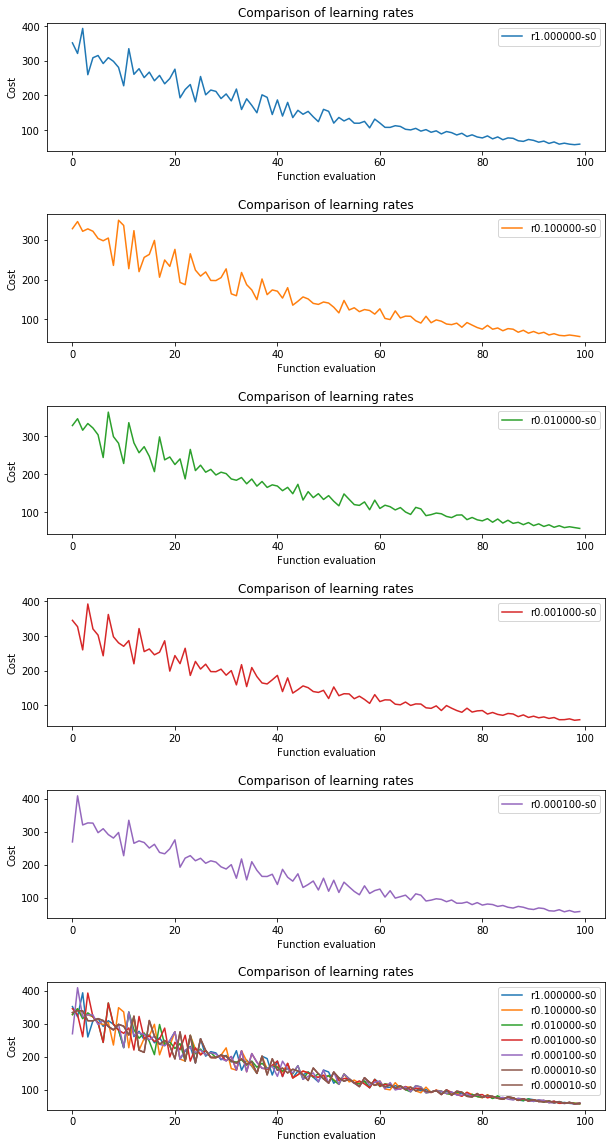

In [51]:
fig, axs = plt.subplots(nrows=len(learningRates + 1), figsize=(10, 20))
for i, learningRate in enumerate(learningRates):
    filename = "deleteme-minibatch-rate-%d/_rank00000.h5" % i
    with h5py.File(filename, 'r') as f:
        trajectory = f['/multistarts/0/iterCostFunCost'][:]
    for start in range(trajectory.shape[0]):
        for ax in (axs[i], axs[-1]):
            ax.plot(trajectory[start], label="r%f-s%d"%(learningRate, start), color="C%d"%i)
            ax.set_xlabel("Function evaluation")
            ax.set_ylabel("Cost")
            ax.set_title("Comparison of learning rates")
            ax.legend()
plt.subplots_adjust(hspace=0.5)

In [53]:
#?plt.subplots_adjust

# TODO

## preeequilibration
## different optimizers
## improve timing

In [ ]:
list(model.getParameterNames())